In [134]:
from data import *
from models import *
import pickle
import collections

%matplotlib inline 
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False 

pd.set_option('display.max_rows', 100)    
pd.set_option('display.max_colwidth', 100)    

%load_ext autoreload
%autoreload 2


data_path = os.getcwd() + "/data"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DATA

In [125]:
kb_file = os.path.join(data_path,'kb_question.csv')
if os.path.exists(kb_file):
    kb_question = pd.read_csv(kb_file)
else:
    kb_question = read_kb(data_path)
    kb_question.to_csv(kb_file , index=False, encoding='utf-8-sig')

original shape:  (35386, 3)
dropping duplicates ...
after dropping duplicates:  (33431, 3)


In [3]:
# display(kb_question.sample(n=100))

In [4]:
train, dev, test = np.split(kb_question.sample(frac=1), [int(.8*len(kb_question)), int(.9*len(kb_question))])

In [5]:
if not os.path.exists(os.path.join(data_path,'train.csv')):
    train_df = create_pair_data(train)
    train_df.to_csv(os.path.join(data_path,'train.csv'), index=False, header=False, encoding='utf_8_sig')
else:
    train_df = pd.read_csv(os.path.join(data_path,'train.csv'), header=None)
    train_df.columns = ['s1', 's2', 'score']
    
if not os.path.exists(os.path.join(data_path,'dev.csv')):
    dev_df = create_pair_data(dev)
    dev_df.to_csv(os.path.join(data_path,'dev.csv'), index=False, header=False, encoding='utf_8_sig')
else:
    dev_df = pd.read_csv(os.path.join(data_path,'dev.csv'), header=None)
    dev_df.columns = ['s1', 's2', 'score']
    
if not os.path.exists(os.path.join(data_path,'test.csv')):
    test_df = create_pair_data(test)
    test_df.to_csv(os.path.join(data_path,'test.csv'), index=False, header=False, encoding='utf_8_sig')
else:
    test_df = pd.read_csv(os.path.join(data_path,'test.csv'), header=None)
    test_df.columns = ['s1', 's2', 'score']

In [6]:
def convert(x):
    if x==0:
        return 0
    if x==3:
        return 1
    if x==5:
        return 2
train_df['score'] = train_df['score'].apply(lambda x: convert(x) )

In [7]:
train, dev, test = get_nl(data_path)

processing /home/tingchunyeh/Sentence_sim/data/train.csv ...
** TRAIN DATA : Found 1446304 pairs of train sentences.
processing /home/tingchunyeh/Sentence_sim/data/dev.csv ...
** DEV DATA : Found 148766 pairs of dev sentences.
processing /home/tingchunyeh/Sentence_sim/data/test.csv ...
** TEST DATA : Found 149162 pairs of test sentences.


In [8]:
txt = np.append(train['s1'], train['s2'])

In [9]:
wv, default_wv = build_vocab(txt, "w2v-model.txt")

Found (5211/5770) words with w2v vectors
vocab size: 5770


In [10]:
test_vec1 = "苏宁 易 购 所 出售 的 商品 均 为 正品 行货 均 来自 正规 渠道 带 正规 机 打 发票 享受 国家 三 包 服务 质量 和 售后 服务 与 门店 完全 相同 请您 放心 选购"
test_vec2 =  "苏宁 易 购 所 出售 的 商品 均 为 正品 行货 请您 放心 选购"
test_vec3 = "有 统一 的 全 国 售后 服务 正品 质量 保证"
test_vec4 = "所有 货物 都 是 正品 请 安心 购买"
test_vec5 = "正规 发票 服务 完全 相同 放心 享受 服务"

## TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle

In [13]:
def TF_IDF_train(txt, min_df=5):
    tf = TfidfVectorizer(norm=None,  min_df=min_df)
    txt_fitted = tf.fit(txt)
#     txt_transformed = txt_fitted.transform(txt)
    idf = dict(zip(txt_fitted.get_feature_names(), tf.idf_))
    
#     feature_names = np.array(tf.get_feature_names())
#     sorted_by_idf = np.argsort(tf.idf_)
#     print("Features with lowest idf:\n{}".format(
#            feature_names[sorted_by_idf[:10]]))
#     print("\nFeatures with highest idf:\n{}".format(
#            feature_names[sorted_by_idf[-10:]]))
    
    return txt_fitted, idf

In [14]:
def TF_IDF_predict(s1, s2):
    tfidf1 = txt_fitted.transform([s1])
    tfidf2 = txt_fitted.transform([s2])
    return cosine_similarity(tfidf1, tfidf2)[0][0]

In [12]:
txt_fitted, idf = TF_IDF_train(txt)
print("Vocabulary size: {}".format(len(idf)))

Vocabulary size: 4814


In [15]:
print(TF_IDF_predict(test_vec1, test_vec2))
print(TF_IDF_predict(test_vec1, test_vec3))
print(TF_IDF_predict(test_vec1, test_vec4))
print(TF_IDF_predict(test_vec1, test_vec5))

0.564063288478027
0.3280959982172061
0.08927000153673949
0.7154883451720517


## Avg word embedding

In [198]:
def avg_embedding(sentence):
    res = np.zeros(300)
    count = 0
    for w in sentence.split():
        cur = wv[w] if w in wv else default_wv
        res = np.add(res, cur)
        count += 1
    return res/count

In [204]:
def avg_embedding_predict(s1, s2):
    avg_embed1 = avg_embedding(s1)
    avg_embed2 = avg_embedding(s2)
    return cosine_similarity([avg_embed1], [avg_embed2])[0][0]

In [205]:
print(avg_embedding_predict(test_vec1, test_vec2))
print(avg_embedding_predict(test_vec1, test_vec3))
print(avg_embedding_predict(test_vec1, test_vec4))
print(avg_embedding_predict(test_vec1, test_vec5))

0.739491326481336
0.7663865996011827
0.5822244566551635
0.8051636726755851


## IDF word embedding

In [17]:
def IDF_embedding(sentence):
    res = np.zeros(300)
    count = 0
    for w in sentence.split():
        if w in wv:
            cur = wv[w]*idf[w] if w in idf else wv[w] 
        else:
            cur = default_wv
        res = np.add(res, cur)
        count += 1
    return res/count

In [18]:
def IDF_embedding_predict(s1, s2):
    IDF_embed1 = IDF_embedding(s1)
    IDF_embed2 = IDF_embedding(s2)
    return cosine_similarity([IDF_embed1], [IDF_embed2])[0][0]

In [21]:
print(IDF_embedding_predict(test_vec1, test_vec2))
print(IDF_embedding_predict(test_vec1, test_vec3))
print(IDF_embedding_predict(test_vec1, test_vec4))
print(IDF_embedding_predict(test_vec1, test_vec5))

0.7698741733717803
0.8521170473109053
0.6059862379190339
0.876640677199962


## Evaluation

In [12]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def predict(s1_ls, s2_ls, ptype='TF_IDF_predict'):
    preds = []
    for idx in tqdm(range(len(s1_ls))):
        s1, s2 = s1_ls[idx], s2_ls[idx]
        preds.append(eval(ptype)(s1, s2))
    return preds

def get_labels(preds, ths=[0.5, 0.7]):
    labels = []
    for pred in preds:
        if pred<ths[0]:
            labels.append(0)
        elif pred<ths[1]:
            labels.append(1)
        else:
            labels.append(2)
    return labels    
    
def eval_plot(pred_labels, true_labels):
    cnf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2], title='Confusion matrix, without normalization')
#     plt.show()
    plt.subplot(1,2,2)
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2], title='Confusion matrix', normalize=True)
    plt.subplots_adjust(wspace = 0.2)
    plt.show()
    
val_acc_best = -1e10
adam_stop = False
stop_training = False

def evaluate(epoch, bsize = 64, eval_type='dev', final_eval=False):
    nli_net.eval()
    correct = 0.0
    global val_acc_best, lr, stop_training, adam_stop
    
    s1 = dev['s1'] if eval_type == 'dev' else test['s1']
    s2 = dev['s2'] if eval_type == 'dev' else test['s2']
    target = dev['label'] if eval_type == 'dev' else test['label']
    labels = np.array([])

    for i in tqdm(range(0, len(s1), bsize)):
        # prepare batch
        s1_batch, s1_len = get_batch(s1[i:i + bsize], wv, default_wv)
        s2_batch, s2_len = get_batch(s2[i:i + bsize], wv, default_wv)
        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[i:i + bsize])).cuda()

        # model forward
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))

        pred = output.data.max(1)[1]
        correct += pred.long().eq(tgt_batch.data.long()).cpu().sum().item()
        
        labels = np.append(labels, pred.cpu().data.numpy())

    # save model
    eval_acc = round(100 * correct / len(s1), 2)
    if final_eval:
        print('finalgrep : accuracy {0} : {1}'.format(eval_type, eval_acc))
    else:
        print('togrep : results : epoch {0} ; mean accuracy {1} :{2}'.format(epoch, eval_type, eval_acc))

    if eval_type == 'dev' and eval_acc > val_acc_best:
        print('saving model at epoch {0}'.format(epoch))
        if not os.path.exists("saved_model"): os.makedirs("saved_model")
        torch.save(nli_net.state_dict(), os.path.join("saved_model", "model_1"))
        val_acc_best = eval_acc

    return labels

def test_onePair(s1, s2):
    nli_net.eval()
    
    s1_batch, s1_len = get_batch(s1, wv, default_wv)
    s2_batch, s2_len = get_batch(s2, wv, default_wv)
    s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())

    # model forward
    output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
    pred = output.data.max(1)[1]
    return pred.item()

def score_onePair(s1, s2):
    nli_net.eval()
    
    s1_batch, s1_len = get_batch(s1, wv, default_wv)
    s2_batch, s2_len = get_batch(s2, wv, default_wv)
    s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())

    # model forward
    output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
    return output.cpu().data[0][2].item()


def encode_sentence(s):
    nli_net.eval()
    s_batch, s_len = get_batch(s, wv, default_wv)
    s_batch = Variable(s_batch.cuda())
    return nli_net.encode((s_batch, s_len)).cpu().data[0]


def cosScore_onePair(s1, s2):
    arr1 = encode_sentence(s1).reshape(1, -1)
    arr2 = encode_sentence(s2).reshape(1, -1)
    return cosine_similarity(arr1, arr2)[0][0]

### TF-IDF

In [23]:
TFIDF_preds = predict(dev['s1'], dev['s2'])

100%|██████████| 120217/120217 [02:03<00:00, 977.02it/s]


overall accuracy: 0.6252110766364158


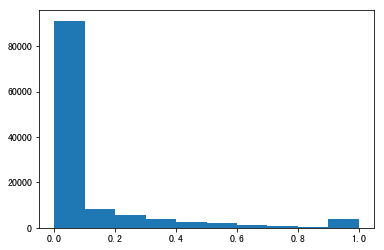

Confusion matrix, without normalization
[[59651   984  6225]
 [19134   468 12267]
 [ 6348    98 15042]]
Normalized confusion matrix
[[0.89217768 0.01471732 0.093105  ]
 [0.60039537 0.01468512 0.38491951]
 [0.2954207  0.00456069 0.70001862]]


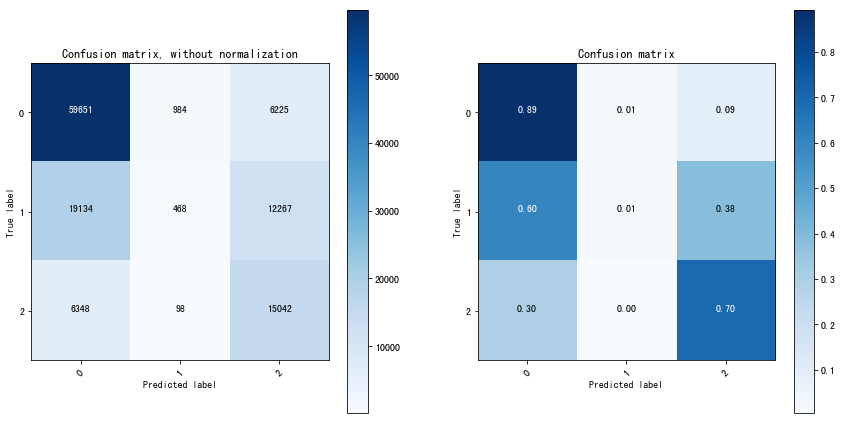

In [24]:
TFIDF_pred_labels = get_labels(TFIDF_preds, ths=[0.01, 0.05])
print("overall accuracy:", float(np.where(TFIDF_pred_labels==dev['label'])[0].shape[0])/len(TFIDF_pred_labels))
plt.figure()
plt.hist(TFIDF_preds)
plt.show()
eval_plot(TFIDF_pred_labels, dev['label'])

### avg word embedding

In [25]:
avg_embed_preds = predict(dev['s1'], dev['s2'], ptype="avg_embedding_predict")

100%|██████████| 120217/120217 [00:27<00:00, 4380.60it/s]


overall accuracy: 0.5329695467363185


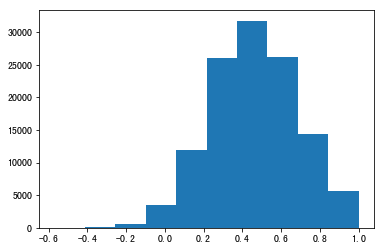

Confusion matrix, without normalization
[[37868 23236  5756]
 [ 8416 11144 12309]
 [ 1776  4652 15060]]
Normalized confusion matrix
[[0.56637751 0.34753216 0.08609034]
 [0.26408108 0.34968151 0.38623741]
 [0.08265078 0.21649293 0.70085629]]


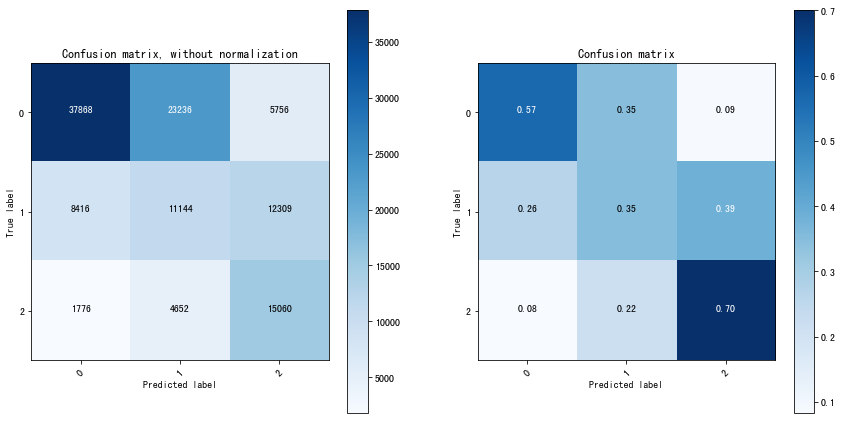

In [26]:
avg_embed_pred_labels = get_labels(avg_embed_preds, ths=[0.4, 0.6])
print("overall accuracy:", float(np.where(avg_embed_pred_labels==dev['label'])[0].shape[0])/len(avg_embed_pred_labels))
plt.figure()
plt.hist(avg_embed_preds)
plt.show()
eval_plot(avg_embed_pred_labels, dev['label'])

### IDF word embedding

In [27]:
IDF_embed_preds = predict(dev['s1'], dev['s2'], ptype="IDF_embedding_predict")

100%|██████████| 120217/120217 [00:31<00:00, 3874.93it/s]


0.5478260146235557


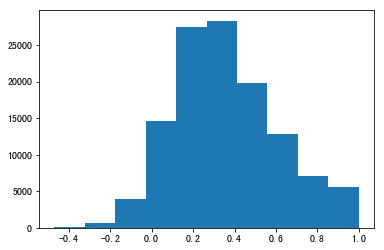

Confusion matrix, without normalization
[[43116 11998 11746]
 [ 8686  5219 17964]
 [ 2069  1896 17523]]
Normalized confusion matrix
[[0.64486988 0.1794496  0.17568053]
 [0.27255326 0.16376416 0.56368258]
 [0.0962863  0.08823529 0.81547841]]


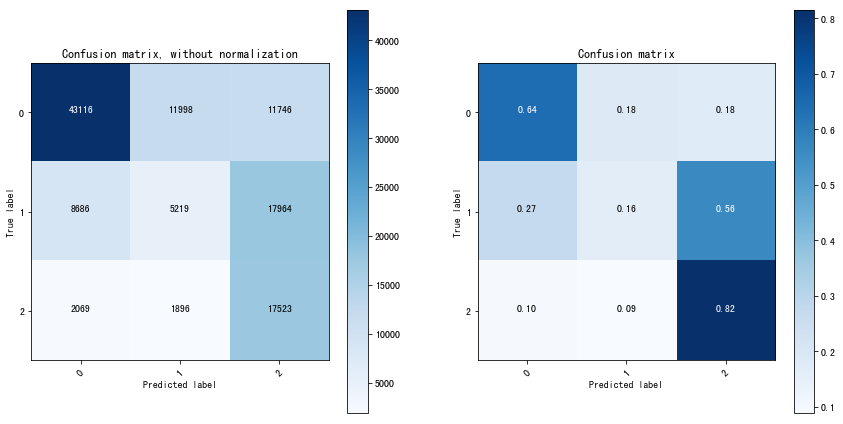

In [28]:
IDF_embed_pred_labels = get_labels(IDF_embed_preds, ths=[0.3, 0.4])
print( float(np.where(IDF_embed_pred_labels==dev['label'])[0].shape[0])/len(IDF_embed_pred_labels))
plt.figure()
plt.hist(IDF_embed_preds)
plt.show()
eval_plot(IDF_embed_pred_labels, dev['label'])

### InferSent Train

In [13]:
from torch import optim

def train_small_epoch(epoch=1, batch_size=64, dpout_embed=0.2, percent=0.1, verbose=False):
    all_costs = []
    tot_costs = []
    logs = []
    correct = 0.0
    nli_net.train()
    permutation = np.random.choice(np.random.permutation(len(train['s1'])), int(percent*len(train['s1'])))
    s1 = train['s1'][permutation]
    s2 = train['s2'][permutation]
    target = train['label'][permutation]
    
    for stidx in range(0, len(s1), batch_size):
        s1_batch, s1_len = get_batch(s1[stidx:stidx+batch_size], wv, default_wv, dpout_embed)
        s2_batch, s2_len = get_batch(s2[stidx:stidx+batch_size], wv, default_wv, dpout_embed)
        
        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[stidx:stidx+batch_size])).cuda()
        
        k = s1_batch.size(1)
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
        
        pred = output.data.max(1)[1]
        correct += pred.long().eq(tgt_batch.data.long()).cpu().sum().item()

        # loss
        loss = loss_fn(output, tgt_batch)
        all_costs.append(loss.item())
        tot_costs.append(loss.item())
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and len(all_costs) == 10:
            logs.append('{0};  loss: {1};  accuracy train: {2}'.format(stidx, 
                            round(np.mean(all_costs), 2), round(100.*correct/(stidx+k), 2)))
            print(logs[-1])
            all_costs = []
            
    train_acc = round(100 * correct/len(s1), 2)
    train_loss = round(np.mean(tot_costs), 2)
    return train_loss, train_acc  

In [20]:
config_nli_model = {
    'n_words'        :  len(wv),
    'word_emb_dim'   :  300,
    'enc_lstm_dim'   :  256,
    'num_layer'   :  1,
    'dpout_model'    :  0,
    'dpout_fc'       :  0.2,
    'fc_dim'         :  256,
    'bsize'          :  64,
    'n_classes'      :  3,
    'pool_type'      :  'max',
    'encoder_type'   :  'GRUEncoder',
    'use_cuda'       :  True,
}

In [12]:
torch.manual_seed(10)
np.random.seed(10)

### Train Playground

In [15]:
from models import *
nli_net = NLINet(config_nli_model)

# loss 
weight = torch.FloatTensor(3).fill_(1)
loss_fn = nn.CrossEntropyLoss(weight=weight)
loss_fn.size_average = False

# optimizer
optimizer = optim.Adam(nli_net.parameters(), lr=0.005)

# cuda 
torch.cuda.manual_seed(10)
torch.cuda.set_device(0)
nli_net.cuda()
loss_fn.cuda()

CrossEntropyLoss()

In [35]:
percent = 0.01
batch_size = 64
dpout_embed = 0.2

nli_net.train()
permutation = np.random.choice(np.random.permutation(len(train['s1'])), int(percent*len(train['s1'])))
s1 = train['s1'][permutation]
s2 = train['s2'][permutation]
target = train['label'][permutation]

for stidx in range(0, len(s1), batch_size):
    s1_batch, s1_len = get_batch(s1[stidx:stidx+batch_size], wv, default_wv, dpout_embed)
    s2_batch, s2_len = get_batch(s2[stidx:stidx+batch_size], wv, default_wv, dpout_embed)

    s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
    tgt_batch = Variable(torch.LongTensor(target[stidx:stidx+batch_size])).cuda()

    k = s1_batch.size(1)
    output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))

    pred = output.data.max(1)[1]

    # loss
    loss = loss_fn(output, tgt_batch)


    optimizer.zero_grad()
    loss.backward()
    print(nn.utils.clip_grad_norm_(nli_net.parameters(), 1.0, norm_type=2))
    optimizer.step()
    
#     for p in nli_net.parameters():
#         print(p.grad.norm())
#     break

0.4770913822725743
0.7630111347285526
0.2901905850017138
0.5270982877546111
0.21935953781244452
0.18755439140935176
0.7008950709282199
0.30876373975188054
0.23508449807319928
1.0190785329237066
0.31442136957198047
1.6114509955899496
1.2310205956344846
0.29668225055518355
0.37299937373727965
0.4464144932976104
0.6992837589348507
0.98853980772403
0.5278060358291804
0.48937840420288364
0.6168165970153694
0.7106414806188912
0.5400663524786569
0.2816607533627098
1.1205539478221906
0.5493400061194812
0.70444132916375
1.1877300968243434
0.6919483514953534
0.2339067149504518
0.7531124205482012
0.4703768421566203
0.45617798743167554
0.5942368284565895
0.29805327569709855
0.7095551255390803
0.6406362686814058
0.7042405726806935
1.0829033979909155
0.2835449925508854
0.677856965253516
0.7954047087912423
0.4544082144912051
0.2614673182146061
1.2680409707224567
0.6216775279514744
0.6955661786099093
0.5072720277622533
0.3505235074565964
0.4951417350823605
0.6603416716342425
0.5583327821033757
0.74644

### Find Best Parameters

In [ ]:
lrs = []
hidden_sizes = []
train_losses = []
train_accs = []
for i in range(100):
    lr = 10**np.random.uniform(-1, -4.5)
    hidden_size = np.random.choice([128, 256, 512])
    lrs.append(lr)
    hidden_sizes.append(hidden_size)
    
    config_nli_model['enc_lstm_dim'] = int(hidden_size)
    from models import *
    nli_net = NLINet(config_nli_model)
    optimizer = optim.Adam(nli_net.parameters(), lr=lr)
    weight = torch.FloatTensor(3).fill_(1)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    loss_fn.size_average = False
    
    nli_net.cuda()
    loss_fn.cuda()
    for i in range(10):
        train_loss, train_acc  = train_small_epoch(1, batch_size=64, dpout_embed=0.2, percent=0.01)
        print("lr: {};  hidden_size: {};  train_loss: {};  train_acc: {}".format(round(lr,4), hidden_size, train_loss, train_acc))
    print("-"*100)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

lr: 0.0019;  hidden_size: 256;  train_loss: 1.11;  train_acc: 35.63
lr: 0.0019;  hidden_size: 256;  train_loss: 1.1;  train_acc: 35.33
lr: 0.0019;  hidden_size: 256;  train_loss: 1.1;  train_acc: 34.62
lr: 0.0019;  hidden_size: 256;  train_loss: 1.11;  train_acc: 35.1
lr: 0.0019;  hidden_size: 256;  train_loss: 1.1;  train_acc: 35.82
lr: 0.0019;  hidden_size: 256;  train_loss: 1.1;  train_acc: 35.83
lr: 0.0019;  hidden_size: 256;  train_loss: 1.1;  train_acc: 34.94
lr: 0.0019;  hidden_size: 256;  train_loss: 1.1;  train_acc: 34.89
lr: 0.0019;  hidden_size: 256;  train_loss: 1.1;  train_acc: 35.66
lr: 0.0019;  hidden_size: 256;  train_loss: 1.1;  train_acc: 35.2
----------------------------------------------------------------------------------------------------
lr: 0.0001;  hidden_size: 512;  train_loss: 1.09;  train_acc: 38.69
lr: 0.0001;  hidden_size: 512;  train_loss: 1.07;  train_acc: 42.19
lr: 0.0001;  hidden_size: 512;  train_loss: 1.04;  train_acc: 46.1
lr: 0.0001;  hidden_size: 

### InferSent Eval

In [63]:
model_name = "model_new2"
with open(os.path.join("saved_model", model_name+"_config.pickle"), "rb") as input_file:
    params = pickle.load(input_file)

In [64]:
config_nli_model = {
    'n_words'        :  len(wv),
    'word_emb_dim'   :  300,
    'enc_lstm_dim'   :  params.enc_lstm_dim,
    'num_layer'      :  params.num_layer,
    'dpout_model'    :  params.dpout_model,
    'dpout_fc'       :  params.dpout_fc,
    'fc_dim'         :  params.fc_dim,
    'bsize'          :  params.batch_size,
    'n_classes'      :  params.n_classes,
    'pool_type'      :  params.pool_type,
    'encoder_type'   :  params.encoder_type,
    'use_cuda'       :  True,
}


In [65]:
torch.cuda.set_device(0)
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [66]:
nli_net = NLINet(config_nli_model)
nli_net.load_state_dict(torch.load(os.path.join("saved_model", model_name)))
nli_net.cuda()
print(nli_net)

NLINet(
  (encoder): GRUEncoder(
    (enc_lstm): GRU(300, 256, bidirectional=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): Tanh()
    (3): Dropout(p=0.2)
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax()
  )
)


In [28]:
eval_labels = evaluate(0, bsize = 64, eval_type='dev', final_eval=False)

100%|██████████| 2302/2302 [01:57<00:00, 19.58it/s]

togrep : results : epoch 0 ; mean accuracy dev :87.84
saving model at epoch 0


0.8783717741607048
Confusion matrix, without normalization
[[62946  2660  1254]
 [ 5721 36654  3739]
 [ 2006  2539 29807]]
Normalized confusion matrix
[[0.94145977 0.03978462 0.01875561]
 [0.12406211 0.79485623 0.08108167]
 [0.05839544 0.07391127 0.86769329]]


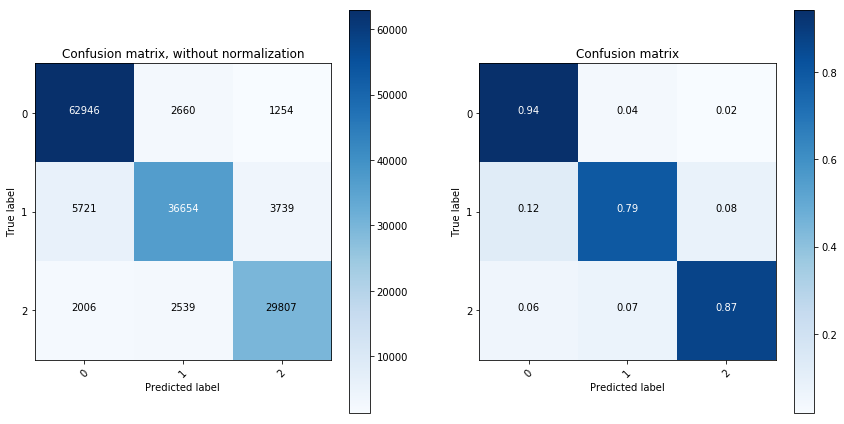

In [29]:
print( float(np.where(eval_labels==dev['label'])[0].shape[0])/len(eval_labels))
eval_plot(eval_labels, dev['label'])

## Error Analysis

In [18]:
train_df = pd.DataFrame(train)

In [401]:
inds = np.where((eval_labels==2) & (dev['label']==2))[0]
for ind in inds:
    print(dev['s1'][ind],"  ", dev['s2'][ind])

没有 看到 发票 下载 的 按钮    电子 发票 下载 的 地址 在 哪里
没有 看到 发票 下载 的 按钮    怎么 没有 下载 发票
没有 看到 发票 下载 的 按钮    电子 发票 下载 的 链接 是 什么
没有 看到 发票 下载 的 按钮    我 找 不 到 下载 电子 发票 的 啊
没有 看到 发票 下载 的 按钮    什么 时候 显示 电子 发票 内容
我 没有 找到 股东券    我 没有 找到 股东券
空调 不 制冷    上 周 只有 1 条 今天 开 电脑 居然 出现 了 4 条
空调 不 制冷    手机 屏幕 失灵 没 反应
是 不 是 能改 别的 支付 方式    是 不 是 能改 别的 支付 方式
请 问 我 购买 的 这 款 产品 是 从 成都 发货 过来 吗    查询 发货 地址
请 问 我 购买 的 这 款 产品 是 从 成都 发货 过来 吗    是 在 那里 发货
请 问 我 购买 的 这 款 产品 是 从 成都 发货 过来 吗    是 从 北京 发货 吗
请 问 我 购买 的 这 款 产品 是 从 成都 发货 过来 吗    优惠 品是 从 哪里 发货 的
什么 时候 退款 到 账呢    已 申请 退货 货款 什么 时间 到 帐
什么 时候 退款 到 账呢    申请 退款 什么 时候 可以 到账
什么 时候 退款 到 账呢    退款 没 收到
什么 时候 退款 到 账呢    请 问 取消 订单 后 我 付 的 款 什么 时候 到账
预售 抢购 到时 怎么 参加    商品 预约 后 马上 抢购么
预售 抢购 到时 怎么 参加    我 可以 参加 预售 活动么
预售 抢购 到时 怎么 参加    我 想 参加 预售 商品
预售 抢购 到时 怎么 参加    预售 抢购 到时 怎么 参加
意外 保 是 发生 意外 用 的 吗    意外 保 是 发生 意外 用 的 吗
我 昨天 零钱 宝 提现 的 到 现在 还 没 到账    我 今天 在 零钱 宝 提现 了 一 笔 钱 到 易 付 宝 余额 可是 一直 没到账
我 昨天 零钱 宝 提现 的 到 现在 还 没 到账    我 今天 早上 从 零钱 宝 转出 到 我 的 易付宝 现在 都 没到账
我 昨天 零钱 宝 提现 的 到 现在 还 没 到账    我

信用 贷借 不 了 钱    任性 贷放 款 失败
信用 贷借 不 了 钱    信用贷 可 用 额度 是 干嘛 的
信用 贷借 不 了 钱    给 了 2000 任 性贷 但是 没 地方 点击 贷款
你们 的 商品 是 不 是 假货    你们 的 商品 是 不 是 假货
我 想 永久 冻结 任性 付 要 怎么办    请 冻结 任性 付
我 想 永久 冻结 任性 付 要 怎么办    注销 任性 付 帐号
我 想 永久 冻结 任性 付 要 怎么办    您 好 我 希望 能 永久 冻结 任性 付
我 想 永久 冻结 任性 付 要 怎么办    太低 了 能 不 能 注销 这个 任性 付的
我 想 永久 冻结 任性 付 要 怎么办    任性 付 可以 关闭 或 注销 吗
如何 参加 满 2 件 5 折 的 活动    如何 参加 满 2 件 5 折 的 活动
如何 参加 满 2 件 5 折 的 活动    要 怎么 参加 满 2 件 5 折 的 活动
易玺 使用 是否 有 限制 能否 使用 多个 账户    易玺 使用 有 没 有 限制 能 不 能 使用 多个 账户
易玺 使用 是否 有 限制 能否 使用 多个 账户    易玺 使用 是否 有 限制 能否 使用 多个 账户
你 好 我 买了 5S 没收 到 前 可以 退货 吗    嗯 呢 给 我 换 吧
你 好 我 买了 5S 没收 到 前 可以 退货 吗    鞋子 385 的 大 太 多 了 我 看 库存 有 一 双 365 的 可以 换 给 我 吗
你 好 我 买了 5S 没收 到 前 可以 退货 吗    买的 诺基亚 n1 要 申请 换货
你 好 我 买了 5S 没收 到 前 可以 退货 吗    不要 了 退货
冲 的 话费 怎么 还 没 到账    我 充值 的 话费 还 没有 到账 帮忙 查询 一下
冲 的 话费 怎么 还 没 到账    我 今天 中午 充的话 费钱 扣 了 没到账
冲 的 话费 怎么 还 没 到账    客服 你 好 为什么 早上 7点40多 冲 话费 现在 还 没 到账
冲 的 话费 怎么 还 没 到账    话费 充值 多久 到账
冲 的 话费 怎么 还 没 到账    交了 流量 费用 为什么 15 分钟 过去 了 还没 到账
快递 没有 给我 提前 打 电话 到 

实名 认证 后 15 元 的 券 没有 到唉    我 昨天 实名 注册 的 会员 优惠券 怎么 还 不 到位 呢
实名 认证 后 15 元 的 券 没有 到唉    实名 给 优惠券 我 刚刚 实名 认证 了 为什么 没 给我
本 以为 今天 下午 可以 收到 的    请 问 现在 拍下 什麽 时候 可以 到
本 以为 今天 下午 可以 收到 的    我 兑换 的 小狮子 什么 时候 发货
本 以为 今天 下午 可以 收到 的    我 下 的 单 还 没 发货 吗 一般 不 是 第二 天 就 到 的 吗
本 以为 今天 下午 可以 收到 的    本 以为 今天 下午 可以 收到 的
麻烦 给 我 一 个 安装 的 联系 电话 谢谢    没有 工作 人员 安装 吗
麻烦 给 我 一 个 安装 的 联系 电话 谢谢    安装 时 你们 会 联系 我妈
麻烦 给 我 一 个 安装 的 联系 电话 谢谢    上门 安装 电视 拨打 哪个 电话
麻烦 给 我 一 个 安装 的 联系 电话 谢谢    帮我 安排 下 安装
新 注册 用户 没有 优惠 么    新 注册 用户 没有 优惠 么
新 注册 用户 没有 优惠 么    新 用户 的 优惠券 在哪
现在 从 易付宝 转账 到 银行卡 需 多长 时间 能到账    转账 信息 填错 了 能 撤销 吗
现在 从 易付宝 转账 到 银行卡 需 多长 时间 能到账    你 好 请问 我 转账 的 钱 为什么 没到 账呢
现在 从 易付宝 转账 到 银行卡 需 多长 时间 能到账    您 好 我 上午 转账 一 笔 钱 到 民生 银行 可是 到 现在 都 没有 到账
现在 从 易付宝 转账 到 银行卡 需 多长 时间 能到账    易付宝 转账 显示 成功 怎么 没到 账啊
现在 从 易付宝 转账 到 银行卡 需 多长 时间 能到账    转账 没 到 账
任性 付 在哪 还款    任性 付 在哪 还款
任性 付 在哪 还款    银行卡 自动 还款 是吗
任性 付 在哪 还款    任性 付 分期 之后 怎么 还款
任性 付 在哪 还款    使用 任性 付 立刻 还款 吗
任性 付 在哪 还款    任性 付 今天 买 什么 时候 还款
是的 那个 榨汁机 优惠券 还没 收到    我的易购券 怎么 还

我 人脸 识别 老是 失败    人脸 识别 怎么 提示 公安 网 无 基准 照片
我 人脸 识别 老是 失败    然后 一直 刷脸 验证 一直 验证 失败 是 什么 情况
我 人脸 识别 老是 失败    你 好 任性 付 人脸 识别 怎么 没 有用
免费 试用 要 怎么 参加 的    免费 试用 要 怎么 参加 的
结果 我 前天 买 昨天 就 给 我 直 降 100 元    我 是 说 退 差价
结果 我 前天 买 昨天 就 给 我 直 降 100 元    这 没 几 天 就 降价 了 我 要 退 差价
结果 我 前天 买 昨天 就 给 我 直 降 100 元    怎么 还 不到 一 个 月 就 降价 了
结果 我 前天 买 昨天 就 给 我 直 降 100 元    你 好 为什么 我 收到 一 天 就 降价
可以 付 现金 吗    货到 付款 必须 现金 吗
可以 付 现金 吗    到货 后 我 就 给 现金 吗
可以 付 现金 吗    这个 是 支持 货到 付款 的 吗
可以 付 现金 吗    只 能 用 现金 到 付吗
北京 节能 补贴 什么 时候 开始 的    北京 节能 补贴 什么 时候 开始 的
厂家 来 维修 贵 不贵    手机 掉 地上 了 能 维修 吗
厂家 来 维修 贵 不贵    海信 空调 维修费 多少
厂家 来 维修 贵 不贵    我 还 在 保呢 不 收 我 维修费 吧
为什么 我 的 任性 贷 额度 没了    为什么 我 的 任性 贷 账户 没有 可消费 的 额度 了
为什么 我 的 任性 贷 额度 没了    我的 任性 贷 额度 没有 了
为什么 我 的 任性 贷 额度 没了    任性 贷冻结 了 能 解封 不
为什么 我 的 任性 贷 额度 没了    为什么 任性 贷 额度 看 不 到了
为什么 我 的 任性 贷 额度 没了    我 任性 贷 额度 被 冻结 了
能 不 能 当天 送来 就 安装    送货 安装 同时 进行 吗
能 不 能 当天 送来 就 安装    能 不 能 当天 送来 就 安装
热水器 送货 后 就 能 安装 吗    我 要 安装 找谁
热水器 送货 后 就 能 安装 吗    我 下单 时 不 是 就 预约 安装 了
热水器 送货 后 就 能 安装 吗    麻烦

微波炉 插上 电源 转动 时间 完全 没 反应    电视 才 买 几 个 月 就 出现 问题 了
我的 发票 还 没来    为什么 我 的 手机 没有 发票
我的 发票 还 没来    我 想 问 下 我 的 发票 开了 没有
出于 安全 考量 希望 能 帮忙 注销 一下 任性 付    任性 付 我 要 注销 下
出于 安全 考量 希望 能 帮忙 注销 一下 任性 付    麻烦 把 任性 付 冻结 一下
出于 安全 考量 希望 能 帮忙 注销 一下 任性 付    任性 付 不 欠款 能否 注销
信用 现金 贷有 额度 怎么 贷不了    信用 贷借 不 了 钱
信用 现金 贷有 额度 怎么 贷不了    任性 贷借 款 为什么 总是 显示 系统 繁忙
信用 现金 贷有 额度 怎么 贷不了    任性 贷暂 时 无法 进行 借款 操作 是 什么 意思
信用 现金 贷有 额度 怎么 贷不了    任性 贷 可以 提现 吗
信用 现金 贷有 额度 怎么 贷不了    任性 贷借 款 为什么 总是 系统 繁忙
我 家里 是 集成 吊顶 你 这个 浴霸 合适 么    我 家里 是 集成 吊顶 你 这个 浴霸 合适 么
我 家里 是 集成 吊顶 你 这个 浴霸 合适 么    怎么 看 浴霸 是 不 是 适合 集成 吊顶
我 申请 冻结 了 任性 付 我 想 问问 什么 时候 才 能 申请 注销 账户    现在 我 要 注销 任性 付
我 申请 冻结 了 任性 付 我 想 问问 什么 时候 才 能 申请 注销 账户    任性 付 申请 冻结
我 申请 冻结 了 任性 付 我 想 问问 什么 时候 才 能 申请 注销 账户    预约 的 理财 一般 要 多久
我 申请 冻结 了 任性 付 我 想 问问 什么 时候 才 能 申请 注销 账户    你 好 我 想 注销 我 的 任性 付 账户
我 申请 冻结 了 任性 付 我 想 问问 什么 时候 才 能 申请 注销 账户    要求 必须 注销 任性 付
为什么 我 的 任性 贷 没有 成功 啊    为什么 我 的 任性 贷 没有 成功 啊
为什么 我 的 任性 贷 没有 成功 啊    任性 贷拒 绝 了 什么 时候 再 可以 申请
东西 送来 的 时候 包装 里面 没有 发票    发票 什么 时候 寄 出

还有 就是 怎么 注销 任性 付    能 不 能 帮我 申请 注销 任性 付 我 已经 把 所有 款项 已经 还清
早上 充值 100 话费 怎么 没 充上    客服 你 好 为什么 早上 7点40多 冲 话费 现在 还 没 到账
早上 充值 100 话费 怎么 没 充上    你 好 我 在 易 付 宝上充 值了 手机 话费 怎么 这么 久 了 还没 到账
早上 充值 100 话费 怎么 没 充上    我 上午 给 手机 充话费 系统 订单 显示 充值 成功 但是 手机 没有 收到 充值 短信
早上 充值 100 话费 怎么 没 充上    冲 的 话费 怎么 还 没 到账
早上 充值 100 话费 怎么 没 充上    你 好 我 交了 200 元 话费 充值 没到账
安排 工人 上门 维修 啊    我 之前 买 的 樱花 T95105 脱水机 坏 了 怎样 联系 维修
安排 工人 上门 维修 啊    跟 谁 预约 维修 啊
安排 工人 上门 维修 啊    你 好 此款 产品 怎么 保修
安排 工人 上门 维修 啊    你 好 之前 在 你们 那 买 的 手机 现在 黑屏 好烫 怎么 弄 都 没 反应
如果 没有 发票 保修 吗    如果 没有 发票 保修 吗
如果 没有 发票 保修 吗    手机 的 发票 丢了 维修 怎么办
如果 没有 发票 保修 吗    保修卡 找 不 到 了 能 不 能 保修
如果 没有 发票 保修 吗    我 在 苏宁 易 购买 的 随货 送来 的 发票 不 清楚 以后 能 保修 吗
如果 没有 发票 保修 吗    如果 发票 掉了 可以 报修 吗
那么 实体 店 发货 是 什么 快递    为什么 不 是 苏宁 快递 送货 而 是 圆通
增票 需要 多少 天 可以 重新 认证    增票 需要 多少 天 可以 重新 认证
增票 需要 多少 天 可以 重新 认证    增票 可以 重新 认证 修改 么
为什么 任性 付 不 能 充话费    为什么 任性 付冲 不 了 话费
为什么 任性 付 不 能 充话费    充话费 就 没 任性 付 付款 的
为什么 任性 付 不 能 充话费    为什么 我 不 能 用 任性 付充 话费
为什么 任性 付 不 能 充话费    任性 付充 话费 不 能 用
为什么 任性 

我 发票 上 的 校验码 在哪    哪里 可以 看 我 的 发票 校验码
我 发票 上 的 校验码 在哪    发票 验证 码 哪里 可以 看到
写的 几 点 就 是 几 点 送 吗    写的 几 点 就 是 几 点 送 吗
多 商标 注册证 品牌 名称 一样 但 经营 商品 范围 不同 上传 商标 注册 的 时候 怎么 处理    多 商标 注册证 品牌 名称 一样 但 经营 商品 范围 不同 上传 商标 注册 的 时候 怎么 处理
为什么 领 不 了 优惠券    为什么 领 不 了 优惠券
为什么 领 不 了 优惠券    无法 领券 为什么
为什么 领 不 了 优惠券    券领券 失败 了
没有 通知 我 就 直接 退货 了 你们 解释 下    收货 没有 验货 的么
没有 通知 我 就 直接 退货 了 你们 解释 下    师傅 不 给 我 送到 指定 的 地方 呢
半 月 之内 可以 补差 价 吗    买贵 就 买贵 了
半 月 之内 可以 补差 价 吗    结果 我 前天 买 昨天 就 给 我 直 降 100 元
半 月 之内 可以 补差 价 吗    一 个 星期 都 不到 就 降价 了
现在 信用贷 为什么 不 能 用了    为什么 任性 贷的 信用 贷款 操作 不了
现在 信用贷 为什么 不 能 用了    你 好 最近 任性 贷 提示 系统 繁忙 是 怎么 回 事
现在 信用贷 为什么 不 能 用了    任性 贷有 额度 为什么 会 借 不到
现在 信用贷 为什么 不 能 用了    信用 贷款 提示 系统 繁忙
我 买 了 两 台 空调 想问 下 安装 咋 收费 的 呀    上面 写 的 同 一 个 地点 安装费 最 多 收 200
我 买 了 两 台 空调 想问 下 安装 咋 收费 的 呀    回风 管 加长 怎么 收费
我 买 了 两 台 空调 想问 下 安装 咋 收费 的 呀    不是说 你们 不 收 安装 费么
我 买 了 两 台 空调 想问 下 安装 咋 收费 的 呀    安装 的 时候 什么 需要 收费
我 买 了 两 台 空调 想问 下 安装 咋 收费 的 呀    安装费 怎么办
电视 才 买 几 个 月 就 出现 问题 了    安排 工人 上门 维修 啊
电视 才 买 几 个 月 就 出现 问题 了

不 配送 呢 可以 自提 吗    现在 不 想 自提 了 能改 吗
不 配送 呢 可以 自提 吗    自提改 配送 怎么 不 能 操作
不 配送 呢 可以 自提 吗    为什么 不 能改 配送 方式
我们 平时 看 万分 收益 还是 年 化 收益    我们 平时 看 万分 收益 还是 年 化 收益
你 能 跟我 说 下 什么 是 安心 保 吗    你 能 跟我 说 下 什么 是 安心 保 吗
你们 可 不 可以 再 优惠 了    电视 有 什么 优惠
你们 可 不 可以 再 优惠 了    我 买的 手机 能不能 便宜 点
我的 预期 收益 通过 什么 标准 算    我的 预期 收益 通过 什么 标准 算
都 是 几 月份 的    什么 叫 日期 不新鲜
都 是 几 月份 的    这个 日期 可以 变
都 是 几 月份 的    日期 新鲜 嘛
都 是 几 月份 的    日期 都 是 最新 的 吗
我 零钱 宝 转 钱 转 了 到 一 张 报废 的 卡里    为什么 零钱 宝 里面 的 钱 不 能 全 转到 建设 银行 上面 另外 一 张 卡 反而 可以
我 零钱 宝 转 钱 转 了 到 一 张 报废 的 卡里    零钱 宝 里面 的 钱 为什么 不 能 全部 转出
我 零钱 宝 转 钱 转 了 到 一 张 报废 的 卡里    我 零钱 宝 转 钱 转 了 到 一 张 报废 的 卡里
话费 充错 了 能 退 吗    我 想 问 下 刚才 有 个 电话 充值 冲 错 了 如何 撤销 订单
话费 充错 了 能 退 吗    话费 充错 了 能 退 吗
话费 充错 了 能 退 吗    话费 充错 了 退款
话费 充错 了 能 退 吗    我 充值 流量 号码 错误 了 怎么办
话费 充错 了 能 退 吗    话费 充错 了 怎么办
交易 完 后 怎么 领 云 钻    打卡 说给 云 钻 2 天 了 怎么 还 没 到账
交易 完 后 怎么 领 云 钻    买 了 东西 为啥 不返 云钻
交易 完 后 怎么 领 云 钻    我 的 订单 怎么 没有 返 2 的 云钻
买 了 好多 东西 现在 怎么 又 一样 没到 呢    错 送 或 漏 送 东西 怎么办
买 了 好多 东西 现在 怎么 又 一样 没到 呢    买 了 三 样 东西 

怎么 更换 申请 的 易付宝 实名 验证    怎么 解除 易 付 宝 身份证 绑定
两 天 前 刚刚 买的 6 s 今天 只要 4665 能 补差 价 不    万一 便宜 补差 价 吗
两 天 前 刚刚 买的 6 s 今天 只要 4665 能 补差 价 不    今天 就 比 昨天 便宜 100
定金 团 商品 如何 支付 定金    定金 团 商品 如何 支付 定金
定金 团 商品 如何 支付 定金    支付 定金 能 不 能 使用 苏宁卡
中国 大陆 没有 注册 商标 的 品牌 是否 可以 入驻 苏宁    品牌 在 中国 大陆 没有 注册 商标 还 能 入驻 苏宁吗
中国 大陆 没有 注册 商标 的 品牌 是否 可以 入驻 苏宁    中国 大陆 没有 注册 商标 的 品牌 是否 可以 入驻 苏宁
中国 大陆 没有 注册 商标 的 品牌 是否 可以 入驻 苏宁    品牌 在 中国 大陆 没有 注册 商标 入驻 苏宁 时有 什么 障碍 吗
任性 付 无法 注销    想 注销 任性 付
任性 付 无法 注销    任性 付 无法 注销
任性 付 无法 注销    任性 付 怎么 注销
任性 付 无法 注销    我 需要 冻结 任性 付 这个
任性 付 无法 注销    任性 付 不 怎么 用 了 可以 冻结 吗
我 这个 商品 使用 的 什么 物流    那么 实体 店 发货 是 什么 快递
我 这个 商品 使用 的 什么 物流    你们 是 委托 第三 方 快递 吗
我 这个 商品 使用 的 什么 物流    你们 是 自己 的 送货员 还是 其它 快递
我 这个 商品 使用 的 什么 物流    我 这个 订单 是 苏宁 自己 送货 吗
我 充值 的 话费 还 没有 到账 帮忙 查询 一下    流量 充值 没有 到账
我 充值 的 话费 还 没有 到账 帮忙 查询 一下    为什么 我 话费 充值 没有 到
我 充值 的 话费 还 没有 到账 帮忙 查询 一下    我 上午 充话费 30 为啥 没有 到账
我 充值 的 话费 还 没有 到账 帮忙 查询 一下    我 手机 话费 充值 未 到 帐 什么 情况
我 充值 的 话费 还 没有 到账 帮忙 查询 一下    我 今天 中午 充的话 费钱 扣 了 没到账
是 不 是 第一 次 用完

下面 的 乡镇 可以 到 吗    物流 能到 香格里拉 吗
我 请假 在家 等 了 一 天 为什么 没 人 来    我 家 空调 现在 还 没 装
我 请假 在家 等 了 一 天 为什么 没 人 来    我 请假 在家 等 了 一 天 为什么 没 人 来
任性 付 是 什么    任性 付 是 什么
请 问 我 怎么 查看 下 推广 收益 情况    请 问 我 怎么 查看 下 推广 收益 情况
为什么 有些 商品 不 支持 货到 付款 呢    送到 支付 只 能 付现 金吗
为什么 有些 商品 不 支持 货到 付款 呢    为什么 有些 商品 不 支持 货到 付款 呢
为什么 有些 商品 不 支持 货到 付款 呢    能 到货 付 吗
为什么 有些 商品 不 支持 货到 付款 呢    我 也 可以 货到 付款 是 吧
实名 的 优惠券 还 没 到账    昨天 我 完成 了 注册 并 完成 了 实名 认证 绑卡 但是 没有 发放 优惠券
实名 的 优惠券 还 没 到账    我 做完 实名 认证 可是 没有 领到 15 元券
实名 的 优惠券 还 没 到账    我 刚 看到 有 实名 认证 绑定 银行卡 赠 优惠券 的 活动 我 就 实名 绑 定了 没到 帐啊
实名 的 优惠券 还 没 到账    为什么 我 绑 定了 没有 优惠券
快递 电话 发 一下    我 查 不到 货到 哪里 了 啊
快递 电话 发 一下    物 流到 哪里 了
为什么 任性 贷给 了 额度 又 不 成功    信用 贷款 提示 系统 繁忙
为什么 任性 贷给 了 额度 又 不 成功    任性贷 系统 提示 暂 不 提供 借款 操作
我的易购券 怎么 还 没 到账    我 已经 成功 付款 请问 说好 的 返还 券呢
我的易购券 怎么 还 没 到账    我 的 优惠券 没 返还 怎么办
我的易购券 怎么 还 没 到账    我 到 现在 还 没有 收到 10 元券
我的易购券 怎么 还 没 到账    领劵 没到账
我的易购券 怎么 还 没 到账    为什么 领 的 劵没 到 账啊
支持 无理由 退货 吗    要是 有 质量 问题 换机 在 哪里 换
支持 无理由 退货 吗    过 保 的 商品 还 能 退换 嘛
支持 无理由 退货 吗    苹果 手机 激

任性 贷借 款 还完 还 能 再 借 吗    那个 借款 我 怎 借 不 出来 了 呢 试 了 几 次 呢
易付宝 账户 被 锁去 哪里 解决    易付宝 账户 被 锁 如何 解决
易付宝 账户 被 锁去 哪里 解决    易付宝 账户 被 锁去 哪里 解决
我的 任性 付 欠款 已经 还清 需要 出示 我 欠款 还清 的 证明    为什么 我 的 任性 贷的 结清 证明 还没 发 邮件 给 我 呢
我的 任性 付 欠款 已经 还清 需要 出示 我 欠款 还清 的 证明    开 结 任性 付清 证明 流程 什么样的
我的 任性 付 欠款 已经 还清 需要 出示 我 欠款 还清 的 证明    我的 任性 付 欠款 已经 还清 需要 出示 我 欠款 还清 的 证明
我的 任性 付 欠款 已经 还清 需要 出示 我 欠款 还清 的 证明    我 还 要 出 个 任性 贷的 结清 证明
我 想 知道 固 收乐 享 和 渤享 为什么 提前    我 想 知道 固 收乐 享 和 渤享 为什么 提前
任性 付 购买 的 东西 的 范围    你 好 我 的 任性 付交 话费 怎么 不 能 用了 呀
任性 付 购买 的 东西 的 范围    为什么 我 用 任性 付充值 手机 话费 无法 充值 了 呢
任性 付 购买 的 东西 的 范围    充话费 就 没 任性 付 付款 的
任性 付 购买 的 东西 的 范围    充话费 怎么 不 能 用 任性 付
任性 付 购买 的 东西 的 范围    门店 可以 用 任性 付么
验货 时候 不 能 激活 怎么 看 是 不 是 正品    怎么 验货 怎样 检验 是否 是 行货 正品
不解决 让 315 帮 我了    只 能 求助 12315 了
我的 帐号 任性 付 冻结 了    请 问 这个 冻结 任性 付 什么 时候 能 解冻
任性 付 好久 可以 注销    请 帮我 把 任性 付 注销
任性 付 好久 可以 注销    麻烦 把 任性 付 冻结 一下
任性 付 好久 可以 注销    怎么 关闭 任性 付 怎么 注销 账号
任性 付 好久 可以 注销    注销 苏宁 帐号 任性 付 也 不 会 消失 吗
任性 付 好久 可以 注销    任性 付 我 也 要 注销
之前 网页 上 说 明天 能 送达 的    

任性 付 当前 存在 风险    任性 付 当前 存在 风险
任性 付 当前 存在 风险    任性 付 老是 说 该 订单 存在 风险
任性 付 当前 存在 风险    怎么 我 任性 付 提示 存在 风险
你们 明明 说 今天 已经 发 了 的    连 快递 单号 都 没有
你们 明明 说 今天 已经 发 了 的    帮我 看下 洗衣机 什么 时候 能送
你们 明明 说 今天 已经 发 了 的    我 下 的 单 还 没 发货 吗 一般 不 是 第二 天 就 到 的 吗
一般 如何 保修 呢    我 是 找 你们 维修 还是 找 厂家 呢
一般 如何 保修 呢    售后 服务 找谁 啊
一般 如何 保修 呢    我 这个 空调 坏 了 怎么 维修 啊
一般 如何 保修 呢    发现 质量 问题 怎么 修 呢
电子 发票 售后 认可 吗    电子 发票 售后 认可 吗
电子 发票 售后 认可 吗    用 电子 发票 可以 进行 售后 吧
电子 发票 售后 认可 吗    维修 可以 使用 电子 发票 吗
实名 认证 时 控股 股东 填 什么    实名 认证 时 控股 股东 填 什么
你们 能否 跟 任性 付 那边 沟通 下 我 想 注销 掉    您 好 我 要 冻结 我 的 任性 付
你们 能否 跟 任性 付 那边 沟通 下 我 想 注销 掉    为什么 我 预约 的 一直 没 成功
你们 能否 跟 任性 付 那边 沟通 下 我 想 注销 掉    你 好 开通 任性 付 的话 如果 以后 不 想 用 了 能 注销 吗 注销 了 会 不 会 产生 费用
你们 能否 跟 任性 付 那边 沟通 下 我 想 注销 掉    我 看到 提示 开通 任性 付 不 可 注销
你们 能否 跟 任性 付 那边 沟通 下 我 想 注销 掉    任性 付 怎么 冻结 啊
都到货 十 天 了 你们 还给 不给 安装    都到货 十 天 了 你们 还给 不给 安装
都到货 十 天 了 你们 还给 不给 安装    明天 再 不 来 安装 我 就 要 投诉 了
都到货 十 天 了 你们 还给 不给 安装    一直 没 人 联系 我 现在 告诉 我 他们 安装 不了
都到货 十 天 了 你们 还给 不给 安装    我的 东西 还 没 人 来 安装
都到货 十 

话费 充错 了 退款    我 刚才 话费 充值 错 了 号码 我 想 弄到 另 一 个 号码 上 可以 吗
话费 充错 了 退款    话费 充错 了 退款
这 款 手表 电话 是 苏宁 自营 商品 吗    是 你们 自营 还是 第三 方
这 款 手表 电话 是 苏宁 自营 商品 吗    这 款 手表 电话 是 苏宁 自营 商品 吗
这 款 手表 电话 是 苏宁 自营 商品 吗    怎么 才 算 苏宁 自营
这 款 手表 电话 是 苏宁 自营 商品 吗    是 苏宁 自营 的 吗
这 款 手表 电话 是 苏宁 自营 商品 吗    如何 区分 是 苏宁 自营 的 商品
苏宁租 机 到期 后 还 机还 需要 自己 付费 吗    苏宁租 机 到期 后 还 机还 需要 自己 付费 吗
网页 上 显示 是 今天 早上 到货 怎么 下午 又 改期    我 4 号 下 的 单 现在 反应 都 么有
网页 上 显示 是 今天 早上 到货 怎么 下午 又 改期    说是 今天 可以 收货 的 还 没到
什么 情况 下 安装 需要 收费 呢    电视 底座 调试 也 要 收费 吗
什么 情况 下 安装 需要 收费 呢    易 购买 的 热水器 安装 师傅 不 收费 吗
什么 情况 下 安装 需要 收费 呢    安装费 怎么办
什么 情况 下 安装 需要 收费 呢    不是说 你们 不 收 安装 费么
双 卡 双 待 单 通 可以 同时 接进 来 2 通 电话 么    双 卡 双 待 单 通 可以 同时 接进 来 2 通 电话 么
我 的 订单 是 包 安装 的 吧    厂家 安装 的 怎么 联系
我 的 订单 是 包 安装 的 吧    我 的 订单 是 包 安装 的 吧
我 的 订单 是 包 安装 的 吧    有 没 有 安装 服务 啊
今天 不 会 派送 吗    请 问 现在 拍下 什麽 时候 可以 到
任性 贷我 要 借款 点击 显示 帐号 不 存在 是 什么 意思    我 任性 贷借 钱 额度 有 我 点击 他 说 帐号 不 存在 是 什么 意思
任性 贷我 要 借款 点击 显示 帐号 不 存在 是 什么 意思    我 一点 还款 就是 任性贷 帐号 不 存在
任性 贷我 要 借款 点击 显示 帐号 不 存在 是 什么 意思    我 想 

麻烦 明天 早点 安排 过来 帮 我们 安装 啊    货 已经 收到 了 已经 安装 好了
麻烦 明天 早点 安排 过来 帮 我们 安装 啊    哪里 可以 约 明天 安装
麻烦 明天 早点 安排 过来 帮 我们 安装 啊    到时 安装 找谁
麻烦 明天 早点 安排 过来 帮 我们 安装 啊    你 看 一下 能 不 能 帮我 安排 明天 下午 安装
苏宁 自营 店发 什么 快递    你们 使用 什么 快递呢
苏宁 自营 店发 什么 快递    我 买 任何 快递
苏宁 自营 店发 什么 快递    你们 是 哪个 快递 寄的
苏宁 自营 店发 什么 快递    是 什么 物流 公司
苏宁 自营 店发 什么 快递    是 哪家 物流 公司
是 送货 上门 还是 自己 去取    师傅 只 送到 几 楼
是 送货 上门 还是 自己 去取    你们 的 送货 范围 是 哪些
是 送货 上门 还是 自己 去取    是 只 放在 家门口 吗
是 送货 上门 还是 自己 去取    没有 电梯 也 能送 吗
要 我 自己 打 电话 预约 安装 服务 吗    可以 把 按 装人 的 电话 给 我 吗
要 我 自己 打 电话 预约 安装 服务 吗    那 请问 空调 几时 才 能 上门 安装
要 我 自己 打 电话 预约 安装 服务 吗    你 看 一下 能 不 能 帮我 安排 明天 下午 安装
要 我 自己 打 电话 预约 安装 服务 吗    为啥 要 预约 师傅
零钱 宝 收益 怎么 计算    为什么 零 钱包 没有 收益
零钱 宝 收益 怎么 计算    零钱 宝 这个 钱 怎么 算 的 和 支付 宝 一样 吗
零钱 宝 收益 怎么 计算    零钱 宝 收益 怎么 计算
零钱 宝 收益 怎么 计算    零钱 宝 收益 何时 可以 显示
换 空调 需要 拆机费吗    换 空调 需要 拆机费吗
支付 定金 能 不 能 使用 苏宁卡    定金 团 商品 如何 支付 定金
支付 定金 能 不 能 使用 苏宁卡    支付 定金 能 不 能 使用 苏宁卡
出差 后 再 去 自提 可以 吗    自提 能 不 能 改下 收货 时间 呢
出差 后 再 去 自提 可以 吗    到了 自提点 的 订单 能 不 能 修改 取货 时间
出差 后 再 去 自提

你 好 请问 如何 注销 任性 付    为什么 我 预约 的 一直 没 成功
你 好 请问 如何 注销 任性 付    我 想 永久 冻结 任性 付 要 怎么办
你 好 请问 如何 注销 任性 付    如何 永久性 冻结 任性 付
你 好 请问 如何 注销 任性 付    帮我 冻结 下 任性 付
还是 这 一 套 那 就 315 见 吧    如果 苏宁 不 管我 就 投诉 315
还是 这 一 套 那 就 315 见 吧    所以 我 才 投诉 太 过分 玩 人
解释 一下 企业 商号    解释 一下 企业 商号
解释 一下 企业 商号    能 解释 一下 企业 商号 是 什么 吗
我的 任性贷 还款 点 不 进去 一点 进去 就是 账户 不 存在    任性 贷我 要 借款 点击 显示 帐号 不 存在 是 什么 意思
我的 任性贷 还款 点 不 进去 一点 进去 就是 账户 不 存在    我 任性 贷 帐号 不 存在
我的 任性贷 还款 点 不 进去 一点 进去 就是 账户 不 存在    我 任性 贷借 钱 额度 有 我 点击 他 说 帐号 不 存在 是 什么 意思
我的 任性贷 还款 点 不 进去 一点 进去 就是 账户 不 存在    显示 账号 不 存在 是 什么 意思
我的 任性贷 还款 点 不 进去 一点 进去 就是 账户 不 存在    账号 为什么 不 存在
怎么 使用 优酷 会员    你们 送 的 优酷 会员 我 用 不 上 怎么 回 事
怎么 使用 优酷 会员    怎么 使用 优酷 会员
手机 提供 代检 服务 吗    手机 提供 代检 服务 吗
零钱包 持有 额度 有 没 有 上限    零钱包 持有 额度 有 没 有 上限
退款 什么 时候 才 给 到账    申请 退款 什么 时候 可以 到账
退款 什么 时候 才 给 到账    那 重新 下单 · 我的款 能 马上 退 ·
退款 什么 时候 才 给 到账    退款 到 账后 有 短信 通知 吗
退款 什么 时候 才 给 到账    退款 没 收到
以前 的 订单 现在 查 不到 怎么 操作    为什么 看不到 以前 的 订单 了
以前 的 订单 现在 查 不到 怎么 操作    以前 的 订单 现在 查 不到 怎么 操作
我 都 订购 完成 了 你 和 我 说

安心 保 保障 金额 是 所有 的 都 免费 吗    安心 保 保障 不 就 是 维修 不 收 我 钱 吗
安心 保 保障 金额 是 所有 的 都 免费 吗    你们 这个 安心 保 是 怎么 收 维修费 的 啊
安心 保 保障 金额 是 所有 的 都 免费 吗    安心 保 保障 金额 是 所有 的 都 免费 吗
安心 保 保障 金额 是 所有 的 都 免费 吗    我 买 了 安心 保 维修 时 怎么 收费 呢
安心 保 保障 金额 是 所有 的 都 免费 吗    安心 保 到时候 维修 费用 怎么 算
我 昨天 实名 注册 的 会员 优惠券 怎么 还 不 到位 呢    我 已经 实名 了 为什么 15 元 易 购券 还没 发放
我 昨天 实名 注册 的 会员 优惠券 怎么 还 不 到位 呢    易付宝 实名 认证 15 元 的 券 在 哪里
我 昨天 实名 注册 的 会员 优惠券 怎么 还 不 到位 呢    实名 认证 没有 领券
是 用 苏宁卡 接收 不 到 验证 码    那 为什么 手机 收 不 到 验证 码
是 用 苏宁卡 接收 不 到 验证 码    是 用 苏宁卡 接收 不 到 验证 码
我的 任性 贷还款 未 逾期 怎么 还款 后 额度 为 0    任性 贷 额度 为 0 是 被 冻结 了 吗
我的 任性 贷还款 未 逾期 怎么 还款 后 额度 为 0    我的 任性贷 上面 金额 怎么 显示 为 0
我的 任性 贷还款 未 逾期 怎么 还款 后 额度 为 0    为何 我 的 任性 贷 额度 没有 了
我的 任性 贷还款 未 逾期 怎么 还款 后 额度 为 0    为什么 我 的 任性 贷还款 正常 有 没 有 逾期 为 社么 要 把 我 的 额度 取消
我的 任性 贷还款 未 逾期 怎么 还款 后 额度 为 0    你 好 我 的 任性 贷 因为 昨晚 还款 失败 逾期 一 天 就 给 冻结 了 吗
为什么 我 任性 付写 亲属 名字 和 电话 都 是 错的    你 好 怎么 开通 任性 付 老是 提示 联系人 电话 真实性 电话 号码 和 姓名 都 是 准确 的
为什么 我 任性 付写 亲属 名字 和 电话 都 是 错的    任性 付 总是 提示 我 输入 正确 的 联系人 姓名 和 手机号
为什么 我 任性 

还有 什么 投诉 渠道 吗    投诉 十 景斋 不 发货
还有 什么 投诉 渠道 吗    厂家 还是 没 上门 安装 能 帮我 投诉 下 吗
还有 什么 投诉 渠道 吗    你 好 怎么 投诉 送货 快递
还有 什么 投诉 渠道 吗    我 看您 也 别 仲裁 了 我 直接 工商局 投诉 得了
外置 WiFi 是 什么 意思    外置 WiFi 是 什么 意思
银行卡 自动 还款 是吗    银行卡 自动 还款 是吗
银行卡 自动 还款 是吗    使用 任性 付 立刻 还款 吗
过年 前 下单 过 完 年后 2 个 月 再 送货 可以 吗    不要 那么 早 送货 我 想 迟 一点 送货
过年 前 下单 过 完 年后 2 个 月 再 送货 可以 吗    我 刚 下 的 订单 改成 本 周日 送货 可以 吗
过年 前 下单 过 完 年后 2 个 月 再 送货 可以 吗    帮我 做 下 延期 收货
过年 前 下单 过 完 年后 2 个 月 再 送货 可以 吗    这个 订单 暂 不 送货 时间 待定
设置 了 委托 提现 规则 银行 账户 没有 在 规定 时间 收到 资金 转入 怎么办    设置 了 委托 提现 规则 银行 账户 没有 在 规定 时间 收到 资金 转入 怎么办
你们 是 哪个 快递 寄的    发票 是 走 哪家 快递
你们 是 哪个 快递 寄的    为什么 不 是 苏宁 快递 送货 而 是 圆通
你们 退货 什么 时候 能 处理 太 慢 了    您 好 退货 会 安排 了 师傅 上门 取货 吗
你们 退货 什么 时候 能 处理 太 慢 了    我 有点 着急 了 怎么 还 没 审核 完毕
你们 退货 什么 时候 能 处理 太 慢 了    请 问 退货 需要 几 日 能 处理 呢
你们 退货 什么 时候 能 处理 太 慢 了    我 刚才 申请 退货 能 把 师傅 电话 发给 我 吗 上门 取 件
请 问 下充 错 号码 了 可以 退回 来不    请 问 下充 错 号码 了 可以 退回 来不
请 问 下充 错 号码 了 可以 退回 来不    我 充值 流量 号码 错误 了 怎么办
请 问 下充 错 号码 了 可以 退回 来不    刚才 冲 话费 电话 号码 错了 怎么办
请 问 下充 错 号码 了 可以 退回 来不

价格 贵 还 能 不 能 优惠 了    这个 能再 便宜 点 吗
价格 贵 还 能 不 能 优惠 了    这个 不 能 便宜 了 啊
电子 卡 可以 自己 选择 面值 吗    苏宁卡 有 什麼 面值
电子 卡 可以 自己 选择 面值 吗    电子 卡 可以 自己 选择 面值 吗
电子 卡 可以 自己 选择 面值 吗    电子 礼品 卡有有 一千 的 吗
为什么 我 的 任性 付免 息券 不 能 用 啊    我的 任性 付 12 期 免 息券 怎么 用 不 了
为什么 我 的 任性 付免 息券 不 能 用 啊    任性 付免 息券 使用
为什么 我 的 任性 付免 息券 不 能 用 啊    有 免 息券 怎么 使用 不了
为什么 我 的 任性 付免 息券 不 能 用 啊    开通 任性 付 就 可以 领取 12 期 免 息券 是吗
为什么 我 的 任性 付免 息券 不 能 用 啊    免息券 一般 是 几 期 的
请 问 退货 需要 几 日 能 处理 呢    我 昨天 提交 的 退货 申请 是 不 是 今天 就 可以 退 了
请 问 退货 需要 几 日 能 处理 呢    昨天 安排 好 退货 但是 不知道 什么 时候 过来 取货
请 问 退货 需要 几 日 能 处理 呢    给 我 退货 的 事 还 没 好吗
你 好 这 款 豆浆机 没 货 啊    下单 以后 短信 提示 我 无货
你 好 这 款 豆浆机 没 货 啊    订单 拍下 送货 时 送货 师傅 说 没 货 预计 多久 能 有 货
你 好 这 款 豆浆机 没 货 啊    你 好 这 款 豆浆机 没 货 啊
你 好 这 款 豆浆机 没 货 啊    为什么 内蒙古 包头市 无货 呢
差 2 个 滤芯请 补发 下    不 是 天然气 的 发 错了
零钱 宝有 哪 几 种 可以 转出    零钱 宝有 哪 几 种 可以 转出
你 这个 货 送到 农村 去 吗    你们 的 送货 范围 是 哪些
你 这个 货 送到 农村 去 吗    地址 在 乡下 能 送货 上门 不
易付宝 的 密码 老是 输 不到    输入 支付 密码 没有 效果
易付宝 的 密码 老是 输 不到    易付宝 的 密码 老是 输 不到
我 要 改 一下 维修 电话    厂家 维修 的 怎么 改 时间
我

同时 买 两 台 有 优惠 么    买 两 个 怎么样 也 要 优惠 啊
同时 买 两 台 有 优惠 么    电视 有 什么 优惠
同时 买 两 台 有 优惠 么    我 朋友 还 想 买 一 个 可以 按 六一 的 价格 我 再 买 一 个 吗
同时 买 两 台 有 优惠 么    你 好 买 的 多 有 优惠 吗
内置 WiFi 是 什么 意思    内置 WiFi 是 什么 意思
申请 维修 服务    安排 工人 上门 维修 啊
申请 维修 服务    我的 手机 电源键 按 不 动了
商户 表示 公司 注销 如何 操作 重置 支付 密码    商户 表示 公司 注销 有 什么 方法 重置 支付 密码
商户 表示 公司 注销 如何 操作 重置 支付 密码    商户 表示 公司 注销 去 哪里 重置 支付 密码
商户 表示 公司 注销 如何 操作 重置 支付 密码    商户 表示 公司 注销 如何 操作 重置 支付 密码
商户 表示 公司 注销 如何 操作 重置 支付 密码    商户 表示 公司 注销 重置 支付 密码 的 路径 是 什么
我 怎么 没 收到 退款 啊    还没有 退款 呢
我 怎么 没 收到 退款 啊    钱 什么 时候 退给我
我 怎么 没 收到 退款 啊    昨天 电视 的 退款 怎么 还 没 到 啊
我 怎么 没 收到 退款 啊    请 问 下 我 已经 取消 的 订单 什么 时候 回 款呢
预计 什么 时候 发货    今天 还 到 不了吗
预计 什么 时候 发货    你们 明明 说 今天 已经 发 了 的
任性 付 APP 怎么 修改 手机号    可以 修改 任性 付 手机 吗
任性 付 APP 怎么 修改 手机号    怎么 改 任性 付 手机 号码
任性 付 APP 怎么 修改 手机号    我 任性 付绑 定的 那个 手机 我 没有 用了 已经 注销 了
任性 付 APP 怎么 修改 手机号    任性 付 APP 怎么 修改 手机号
任性 付 APP 怎么 修改 手机号    怎么 修改 任性 付 的 手机 号码
任性 贷 如何 消费    任性 贷 如何 消费
任性 贷 如何 消费    任性 贷 可以 在 苏宁 易 购 上 买 东西 吗
在 哪 申请 补 打 发票    在 哪 申请 补 打 发票

你们 说的 退款 周期 我 已经 超 了 还没 收到    你 好 请问 我 那个 退款 到 现在 怎么 还 没有 退回
你们 说的 退款 周期 我 已经 超 了 还没 收到    你们 的 退款 周期 是 多久啊
易 购 商品 都 是 同时 发货 吗    易 购 商品 都 是 同时 发货 吗
电视机 不 需要 安装 调试 吗    帮我 安排 下 安装
电视机 不 需要 安装 调试 吗    我 想 预约 安装 抽油烟机 怎么 办 呢
任性 贷拒 绝 了 什么 时候 再 可以 申请    任性贷 为什么 一直 申请 失败
任性 贷拒 绝 了 什么 时候 再 可以 申请    任性 贷拒 绝 了 什么 时候 再 可以 申请
任性 贷拒 绝 了 什么 时候 再 可以 申请    为什么 我 的 任性 贷 没有 成功 啊
怎么 重置 支付 密码    我的 支付 密码 忘了 怎么办
怎么 重置 支付 密码    怎样 重设 支付 密码
怎么 重置 支付 密码    如何 通过 手机号 找回 易付宝 支付 密码
怎么 重置 支付 密码    你 好 我 忘记 了 支付 密码 怎么办
怎么 重置 支付 密码    易付宝 支付 密码 怎么 修改
安装 的 完全 不 专业 还 收 了 我 480 元    安装 的 完全 不 专业 还 收 了 我 480 元
安装 的 完全 不 专业 还 收 了 我 480 元    你们 的 免费 安装 是 骗人 的 吗
安装 的 完全 不 专业 还 收 了 我 480 元    为什么 安装 师傅 说 免费 安装 只是 打 广告 的
安装 的 完全 不 专业 还 收 了 我 480 元    安装 人员 收费 不合理
新人 会员 有 没 有 专属 客服    v1 会员 有 专属 客服 吗
新人 会员 有 没 有 专属 客服    新人 会员 有 没 有 专属 客服
我的 货到 现在 没到 查 也 查 不到 正常 昨天 到    快递 今天 上午 就 到 了 太原 了 怎么 一 天 了 都 没 动静
我的 货到 现在 没到 查 也 查 不到 正常 昨天 到    怎么 还 没 送货 呢
我 充 了 两 次 话费 没有 到账 帮 我 看一下    我 今天 中午 充的话 费钱 扣 了 没到账
我 充 了 两 次 话费 没有 到账 帮 我 

遇到 骗子 怎么 向 你们 举报 反馈    app 上 直接 可以 举报 诈骗 行为 吗
遇到 骗子 怎么 向 你们 举报 反馈    遇到 骗子 怎么 向 你们 举报 反馈
我的 足球 通 会员 可以 电视 上 看 直播吗    我的 足球 通 会员 可以 电视 上 看 直播吗
我的 足球 通 会员 可以 电视 上 看 直播吗    电视 上 能用 足球 通 会员 吗
为什么 我 任性 贷借 款 的 时候 系统 提示 当前 存在 风险 问题    任性贷 贷款 显示 苏宁 金融 系统 检测 检测 到 当前 交易 存在 风险
为什么 我 任性 贷借 款 的 时候 系统 提示 当前 存在 风险 问题    我 这个 任性 贷 什么 老是 系统 存在 风险
为什么 我 任性 贷借 款 的 时候 系统 提示 当前 存在 风险 问题    任性 贷总 说 借款 有 风险
为什么 我 任性 贷借 款 的 时候 系统 提示 当前 存在 风险 问题    任性 贷借 款 有 风险
为什么 我 任性 贷借 款 的 时候 系统 提示 当前 存在 风险 问题    怎么 我 的 号 我 要 任性 贷借 款 就 显示 存在 风险
怎么 修改 任性 付 的 手机 号码    可以 修改 任性 付 手机 吗
怎么 修改 任性 付 的 手机 号码    修改 任性 付 手机 怎么 操作
怎么 修改 任性 付 的 手机 号码    我 任性 付绑 定的 那个 手机 我 没有 用了 已经 注销 了
怎么 修改 任性 付 的 手机 号码    任性 付 APP 怎么 修改 手机号
怎么 修改 任性 付 的 手机 号码    怎么 改 任性 付 手机 号码
昨天 还 跟 我 说 是 上门取    我的 退货 申请 怎么 还 没 确认 啊
昨天 还 跟 我 说 是 上门取    我 申请 的 退货 是否 成功
昨天 还 跟 我 说 是 上门取    退货啥 时候 审批
昨天 还 跟 我 说 是 上门取    您 查 一下 现在 是 退货 中 吗
我 想 问 下 宁波 北仑区 是 哪里 送货 的    是 你们 私自 发货 的
我 想 问 下 宁波 北仑区 是 哪里 送货 的    我的货 不 是 合肥 发货 吗
我 想 问 下 宁波 北仑区 是 哪里 送货 的    自营 都 是 当地 仓发 货 吗


能 不 能 用 指纹 支付    易付宝 指纹 支付 在哪 设置
能 不 能 用 指纹 支付    易付宝 是 不 是 可以 指纹 支付
怎么 申请 恶意 差评 删除    怎么 申请 恶意 差评 删除
点读机 的 资料 下载 网站 是 什么    点读机 的 资料 下载 网站 是 什么
我 订 的 电视 怎么 要 到 南京 发货 呀    是 从 北京 发货 吗
我 订 的 电视 怎么 要 到 南京 发货 呀    不 能 从 沈阳 发货 吗
支持 双面 打印 的 打印机 是 什么 意思    双面 打印 的 打印机 不 需要 在 我们 手动 翻转 纸张 吧
支持 双面 打印 的 打印机 是 什么 意思    支持 双面 打印 的 打印机 是 什么 意思
支持 双面 打印 的 打印机 是 什么 意思    双面 打印 的 打印机 不 需要 我们 手动 操作 翻转 吧
我 得 赠品 为啥 还 没有 给我 ?    承诺 送 的 话筒 架 什么 时候 发货
我 得 赠品 为啥 还 没有 给我 ?    哪里 能 看到 购买 的 商品 是否 有 赠品 呢
我 得 赠品 为啥 还 没有 给我 ?    已经 收货 了 怎么 还 不送 赠品
我 得 赠品 为啥 还 没有 给我 ?    什么 时候 送 赠品 啊
我 得 赠品 为啥 还 没有 给我 ?    赠品 却 查 不到 物流 信息 能 不 能 帮我 查 一下
什么 是 全 网通    请 问这 款机 是 全 网通 吗
什么 是 全 网通    什么 是 全 网通
什么 是 全 网通    双 网通 支持 哪些 网络
我 在 北京 收货 是 哪里 发货 的    不是 在 当地 发货 吗
我 在 北京 收货 是 哪里 发货 的    我 在 郑州 是 从 哪里 发货
我 在 北京 收货 是 哪里 发货 的    这 货 怎么 是 从 北京 发货 的
我 在 北京 收货 是 哪里 发货 的    济南 有 货 怎么 还 从 外地 发
苏宁卡 能 买 什么    实体 礼品 卡 只 能 在 网上 使用
苏宁卡 能 买 什么    您 好 我 想 问 下 这个 苏宁卡 可以 支付 吗
苏宁卡 能 买 什么    苏宁卡 能 买 什么
苏宁卡 能 买 什么    礼品 卡 可以 充话费 吗
苏宁卡 能 买 什么    苏宁卡 

In [91]:
s1 = "哪款 热水器 好"
s2 = "能 推荐 一个 热水器"
s3 = "能 推荐 一个 电视"
s4 = "我 想买 热水器"
print(test_onePair([s1], [s2]))
print(test_onePair([s1], [s3]))
print(test_onePair([s1], [s4]))
print("cosine simalarity between 电视 and 热水器: ", cosine_similarity([wv['电视']], [wv['热水器']])[0][0])

2
0
2
cosine simalarity between 电视 and 热水器:  0.32491392565822147


In [423]:
train_df [ (train_df['s1']=="哪款 热水器 好")  | (train_df['s1']=="能 推荐 一个 热水器") ]

,s1,s2,label


In [92]:
s1 = "我 想 把 地址 改 到 北京"
s2 = "地址 能 改 到 北京"
s3 = "地址 能 改 到 天津"
print(test_onePair([s1], [s2]))
print(test_onePair([s1], [s3]))

2
1


In [425]:
train_df [ (train_df['s1']=="地址 能 改 到 北京") | (train_df['s1']=="地址 能 改到 北京 吗") ]

,s1,s2,label


In [95]:
s1 = "我 把 地址 改 到 北京"
s2 = "能 推荐 热水器"
s3 = "我 退货"
s4 = "可以 改 退货 地址"
s6 = "我 改 退货 地址"

print(test_onePair([s1], [s2]))
print(test_onePair([s1], [s3]))
print(test_onePair([s1], [s4]))
print(test_onePair([s1], [s6]))
print(test_onePair([s4], [s6]))

0
0
0
0
2


In [403]:
inds = np.where((eval_labels==0) & (dev['label']==2))[0]
for ind in inds:
    print(dev['s1'][ind],"\t", dev['s2'][ind])

空调 不 制冷 	 我 购买 的 小米 笔记本 电脑 不到 一 个 月 连接处 裂开 了
什么 时候 退款 到 账呢 	 再 不 退款 我 就 要 投诉 了
我 昨天 零钱 宝 提现 的 到 现在 还 没 到账 	 零钱 宝 转到 银行卡 每天 最多 多少 钱
企业 注册 通过 不了 怎么办 	 我 注册 企业 账户 现在 遇到 了 问题 怎么办
你们 使用 什么 快递呢 	 我 下单 了 问下 这 快递 是 什么
剃须刀 不 是 有 3 个 刀头 的 么送 来 的 怎么 只 有 1 个 	 我的 电脑 不 带 鼠标 吗
剃须刀 不 是 有 3 个 刀头 的 么送 来 的 怎么 只 有 1 个 	 己 经 收到 了 但 4 支 夏士莲 洗 发露 其中 2 支 是 沐浴 露
是 你们 便宜 还是 实体 店 便宜 	 感觉 好 复杂 字面 看上去 就是 5 折
款 已经 扣除 了 怎么 显示 还 让 我 付款 	 付 了 钱 怎么 还是 待 支付
请 问 退 单处理 了 吗 	 你 好 请 尽快 同意 取消 订单 我 要 重新 买 刚才 发票 点 错了
怎么 申请 保价 需要 我 自己 申请 么 	 现在 就 降价 了
怎么 申请 保价 需要 我 自己 申请 么 	 降价 有 没 有 补偿
怎么 申请 保价 需要 我 自己 申请 么 	 冰箱 有 价 保 嘛
怎么 申请 保价 需要 我 自己 申请 么 	 一 个 星期 都 不到 就 降价 了
怎么 申请 保价 需要 我 自己 申请 么 	 又 降价 了 咋回事
发货 日期 	 我 兑换 的 小狮子 什么 时候 发货
不是说 安排 人 过来 给 我 维修 的 吗 	 我的 电水壶 不 能 烧水 了
是 哪家 物流 公司 	 你们 一般 不 用 日日 顺吧
忽然 没 反应 了 是 怎么 回 事 	 空调 不 制冷
忽然 没 反应 了 是 怎么 回 事 	 你 好 我 之前 买 的 突然 就 不 能 充电 了 怎么办
刚才 我 抢购 的 东西 为什么 不 能 付款 了 	 订单 的 有效期 是 几天
货到 了 是 送错 了 请 处理 下 	 我 买的 草莓 味 你们 发成 了 蓝莓味
货到 了 是 送错 了 请 处理 下 	 我 买的 酱油 少 了 一 瓶
货到 了 是 送错 了 请 处理 下 	 差 2 个 滤芯请 补发 

你 好 扫地 机 不知怎么 使用 	 我 这个 是 不 是 高清 智能 语音 的 啊
部分 已 发货 是 什么 意思 难道 一 个 订单 分批 送来 	 电视机 怎么 就 一 个 小 的 大 的 没收 到
部分 已 发货 是 什么 意思 难道 一 个 订单 分批 送来 	 我的 电脑 不 带 鼠标 吗
我 想 问 一下 我 这个 冰箱 还 可以 办 延保 	 碎屏保 怎么 购 的
我 之前 的 膨胀 红包 在 哪里 提现 呢 	 现在 膨胀 红包 找 不 到 入口 了
现在 变成 取消 订单 了 到底 怎么回事 	 我 买的 笔 被 退款 我 不 想 退货
现在 变成 取消 订单 了 到底 怎么回事 	 付 了 钱 自动 给 我 退 了
现在 广发 信用卡 支付 有 什么 活动 	 广发 满减
手机 可 不 可以 设置 安保 啊 	 设置 安保 可以 自己 操作 吗
就是 这样 一直 发 不了 	 本 以为 今天 下午 可以 收到 的
支付 出了 问题 怎么办 	 输入 支付 密码 没有 效果
支付 出了 问题 怎么办 	 易付宝 的 密码 老是 输 不到
支付 出了 问题 怎么办 	 老是 下 不了单
跟 谁 预约 维修 啊 	 微波炉 插上 电源 转动 时间 完全 没 反应
跟 谁 预约 维修 啊 	 我 买的 冰箱 设定 按钮 不动
己 经 收到 了 但 4 支 夏士莲 洗 发露 其中 2 支 是 沐浴 露 	 我 的 买的 东西 没有 赠品 早上 说 的 一 起 给我
收到 的 发票 有误 怎么 办 呢 	 实付 5899 但是 开 的 票 只有 4899
取消 订单 了 钱 还没 返回 咋回事 	 再 不 退款 我 就 要 投诉 了
取消 订单 了 钱 还没 返回 咋回事 	 你们 退款 信用卡 要 多久
可是 我 不 想 退 啊 	 麻烦 你们 给 我 取消 下 退货
可是 我 不 想 退 啊 	 刚才 取消 的 订单 我 想 重新 启用
说好 给 我 返 云 钻 的 怎么 没 给 啊 我 还是 你们 超级 会员 呢 	 交易 完 后 怎么 领 云 钻
哂单 怎么 晒 	 收货 两 个 月 了 可以 评价 晒 单 吗
全新 诺基亚 6二 代 天天 更新 系统 怎么 还是 旧 版本 	 空调 不 制冷
全新 诺基亚 6二 代 天天 更新 系统 怎么 还是 

慢 死 了 快点 转 可以 么 	 转呀
慢 死 了 快点 转 可以 么 	 算了 明天 找 人工 客服
为什么 一直 不 发货 	 送货 服务 已 改期 如 有 疑问 请 联系 在线 客服 或 致电 4008-365-365 什么 意思
好 那 就 电话 投诉 反正 图片 啥 的 我 都 留底 了 	 厂家 还是 没 上门 安装 能 帮我 投诉 下 吗
是 送货 上门 还是 自己 去取 	 新疆 发货 吗
出差 后 再 去 自提 可以 吗 	 货到 自提 柜能 修改 时间 吗
出差 后 再 去 自提 可以 吗 	 自提 超期 会 怎样
货到 了 就 可以 安装 了 吗 	 我 想 安装 老板 的 油烟 机
就是 看好 你们 送货 快 才 买 的 急着用 	 物流 太差 多 天 无 进展
就是 看好 你们 送货 快 才 买 的 急着用 	 我 都 等 一 周 多 了 咋 还 不 上货 啊
就是 看好 你们 送货 快 才 买 的 急着用 	 送货 服务 已 改期 如 有 疑问 请 联系 在线 客服 或 致电 4008-365-365 什么 意思
而且 也 是 限购 的 我 一 个 账号 只 能 买 3 台 	 我 可以 从新 下单 吗
灶具 是 什么 气源 	 139 苏泊尔 电磁 炉 不配 汤锅 的 吗
灶具 是 什么 气源 	 我 就 想 问 一下 小猫 怎么 连接 无 线网 是 直接 连接 吗
灶具 是 什么 气源 	 想问 下 这 款 宝贝 没有 来电 提醒 吗
为什么 今天 收到 手机 后 没有 发票 呢 	 发票 是 在 箱子 里 还是 快递 另发
那 你们 快递 是 	 你们 一般 不 用 日日 顺吧
任性 贷刷 脸 总 失败 	 我 一直 刷 不 上脸
拆外机 和 谁 联系 	 我 买 空调 你们 能 给 我 把 旧 机器 移走 吗
不 会 刚 买 几 天 就 降价 了吧 	 这 电话 买 不 到 一 个 月 就 掉价 了 啊
发 圆通 吗 	 不 是 日日 顺吗
我 下单 了 问下 这 快递 是 什么 	 发 圆通 吗
复合 你们 送货 时间 	 能 不 能 尽快 发货
复合 你们 送货 时间 	 刚 你 说 ： 要是 今天 的话 会 是 立即 拿 货 的
为什么 安装 师傅 说 免费 安装 只是 打 广告 的 	 空调 自带 零件 的 材料 问题 

售后 工程师 怎么 乱 收费 	 空调 自带 零件 的 材料 问题 我 没有 义务 掏钱 更换 材料
我的 收货 时间 写错 了 帮我 改下 	 请 问 我 的 烤箱 订单 可否 指定 日期 送货
我的 收货 时间 写错 了 帮我 改下 	 我 昨天 下 订单 的 所有 商品 都 延期
这个 遥控器 是 蓝 牙 还是 红外 	 你 好 扫地 机 不知怎么 使用
这个 遥控器 是 蓝 牙 还是 红外 	 想问 下 这 款 宝贝 没有 来电 提醒 吗
任性 付 的 满减 活动 怎么 参加 的 	 支付 立减 是 假 的 吧
在 苏宁 门店 购买 的 该 线 上机 退货 谁 负责 	 手环 带着 有 不良 反应 所以 要 退货
在 苏宁 门店 购买 的 该 线 上机 退货 谁 负责 	 不 能 换吗
在 苏宁 门店 购买 的 该 线 上机 退货 谁 负责 	 买的 诺基亚 n1 要 申请 换货
在 苏宁 门店 购买 的 该 线 上机 退货 谁 负责 	 预约 退 换货
有 没 有 抢到 	 你们 抢购 数量 给 了 多少 台 怎么 都 抢 不上
您 好 这 款 手机 现在 没有 赠品 了 吗 怎么 没 给 我 啊 	 你们 那个 电子 狗 记录 仪送 16 G 卡吗
不小心 选错 型号 了 	 不说了 给 我 退 了吧
对 机器 不 满意 功能 不 够多 	 机器 出现 问题 了
对 机器 不 满意 功能 不 够多 	 全新 诺基亚 6二 代 天天 更新 系统 怎么 还是 旧 版本
你们 说的 退款 周期 我 已经 超 了 还没 收到 	 为什么 我 退款 还 没 打 过来
这个 空调 还没 到货 呢 但 我 想 退 了 	 这 2 款 电视 一样 的 价格 不同 款 我 可以 把 之前 的 换成 这个 款么
这个 空调 还没 到货 呢 但 我 想 退 了 	 那 我 是 拒收 退货 吗
这个 空调 还没 到货 呢 但 我 想 退 了 	 这个 单 我 退货 了
这个 空调 还没 到货 呢 但 我 想 退 了 	 冰箱 买 大 了 可以 退吗
这个 空调 还没 到货 呢 但 我 想 退 了 	 有 个 件 不 想 收 了 可以 退
易 购 商品 都 是 同时 发货 吗 	 为什么 送达 时间 不 一样 呢
易 购 商品 都 是 同时 发货 吗 	 我 买的 抱枕 可以 给

In [96]:
s1 = "什么 时候 退款 到账"
s2 = "怎么 还不 退款"
s3 = "怎么 还不 退款 烂 透"
print(test_onePair([s1], [s2]))
print(test_onePair([s1], [s3]))

2
0


In [21]:
s1 = "买的 空调 可以 晚 几天 送"
s2 = "怎么 更改 送货 时间"
s3 = "什么 时候 送"
print(test_onePair([s1], [s2]))
print(test_onePair([s1], [s3]))

2
1


In [461]:
train_df [ train_df['s1'].isin(["买的 空调 可以 晚 几天 送","怎么 更改 送货 时间", "什么 时候 送"]) ]

,s1,s2,label


In [90]:
s1 = "货 我 已经 收到 我 不知道 怎么 签收"
s2 = "在哪 确认 收货"
s3 = "支持 开箱 验 机"
print(test_onePair([s1], [s2]))
print(test_onePair([s1], [s3]))

0
1


In [463]:
train_df [ train_df['s1'].isin(["货 我 已经 收到 我 不知道 怎么 签收", "在哪 确认 收货", "支持 开箱 验 机"]) ]

,s1,s2,label


In [96]:
s1 = "建议 你 可以 提前 拨打 一下 预约 安装"
s2 = "可以 预约 收货 当天 安装 吗 "
s3 = "下单 可以 确认 安装 服务 下单 后 可 通过 以下 链接 确认 服务 信息 或 预约 更改 服务 时间 商家 安装 问题 请 优先 联系 商家 客服"
s4 = "你 帮 我 看看 这 快递 到 哪 了 "
print(test_onePair([s1], [s2]))
print(test_onePair([s1], [s3]))
print(test_onePair([s1], [s4]))

2
2
0


## Test Set

In [196]:
def nn_score(df):
    df['nn_score'] = df[['q', 'sim_q']].apply(lambda x: score_onePair([x[0]],[x[1]]), axis=1)
    df['nn_roundScore'] = df['nn_score'].apply(lambda x: round(x, 3))

def cos_score(df):
    df['cos_score'] = df[['q', 'sim_q']].apply(lambda x: cosScore_onePair([x[0]],[x[1]]), axis=1)
    df['cos_roundScore'] = df['cos_score'].apply(lambda x: round(x, 3))

def result_label(df):
    nn_idx = df.groupby('q_id')['nn_score'].transform(max) == df['nn_score']
    sm_idx = df.groupby('q_id')['score'].transform(max) == df['score']
    cos_idx = df.groupby('q_id')['cos_score'].transform(max) == df['cos_score']
    
    nn_label = df.loc[nn_idx].groupby('q_id')[['sim_q', 'stan_q', 'nn_roundScore']].first()
    sm_label = df.loc[sm_idx].groupby('q_id')[['sim_q', 'stan_q', 'score']].first()
    cos_label = df.loc[cos_idx].groupby('q_id')[['sim_q', 'stan_q', 'cos_roundScore']].first()
    
    q = df.groupby('q_id')[['q', 'exp_q']].first()
    result = pd.concat( [q,sm_label, nn_label, cos_label], axis=1)
    result.columns = ['q', 'exp_q', 'sm_sim_q', 'sm_stan_q', 'sm_score', 'nn_sim_q', 'nn_stan_q', 'nn_score',
                     'cos_sim_q', 'cos_stan_q', 'cos_score']
    return result

def pred_new_score(df, th=0.7):
    df['new_stan_q'] = df[['cos_score', 'sm_score', 'cos_stan_q', 'sm_stan_q']].apply(lambda x: x[3] if x[1]>th else x[2],axis=1)
    
def major_vote(s_ls):
    count = collections.defaultdict(int)
    for s in s_ls:
        count[s] += 1
    sorted_count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)
    if sorted_count[0][1]>1:
        return sorted_count[0][0]
    else:
        return s_ls[-1]

def major_label(df):
    df['major_stan_q'] = df[['sm_stan_q', 'nn_stan_q', 'cos_stan_q']].apply(lambda x: major_vote(x),axis=1)

In [68]:
# test_df = pd.read_csv( os.path.join(data_path, "questions_test_tokenized.csv"))
# test_df.columns = ['q_id', 'q', 'score', 'sim_q', 'stan_q', 'act_q', 'exp_q']
# nn_score(test_df)
# cos_score(test_df)
# test_df.to_csv("questions_test_pred_"+model_name+".csv", index=False, encoding='utf-8-sig')

In [95]:
test_df = pd.read_csv("questions_test_pred_"+model_name+".csv")

In [215]:
test_df.head()

,q_id,q,score,sim_q,stan_q,act_q,exp_q,nn_score,nn_roundScore,cos_score,cos_roundScore
0,1,问地点 领 券,1.00,问地点 领 券,在哪里领券,在哪里领券,在哪里领券,1.000000,1.0,1.000000,1.000
1,1,问地点 领 券,0.77,领 券 地方 问地点,在哪里领券,在哪里领券,在哪里领券,1.000000,1.0,0.627972,0.628
2,1,问地点 领 券,0.77,领 券 页面 问地点,在哪里领券,在哪里领券,在哪里领券,0.999998,1.0,0.602355,0.602
3,1,问地点 领 券,0.87,问地点 能 领 券,在哪里领券,在哪里领券,在哪里领券,1.000000,1.0,0.954721,0.955
4,1,问地点 领 券,1.00,券 问地点 领,在哪里领券,在哪里领券,在哪里领券,1.000000,1.0,0.635273,0.635


In [198]:
result = result_label(test_df)
major_label(result)

In [216]:
result.sample(30)

,q,exp_q,sm_sim_q,sm_stan_q,sm_score,nn_sim_q,nn_stan_q,nn_score,cos_sim_q,cos_stan_q,cos_score,major_stan_q
q_id,,,,,,,,,,,,
855,当时 买 能 当时 安装,提供安装服务吗,能 买 安装 时,怎么预约安装,0.77,你 能 查到 当时 安装 联系,怎么预约安装,1.0,买 前 预约 安装 能,怎么预约安装,0.551,怎么预约安装
1898,售后 怎么 弄,申请售后,售后 怎么 弄,如何预约维修,1.00,售后 怎么 弄,如何预约维修,1.0,售后 怎么 弄,如何预约维修,1.000,如何预约维修
684,换 人工客服,转人工,换 人工客服,转人工,1.00,换 人工客服,转人工,1.0,换 人工客服,转人工,1.000,转人工
669,我有 订单 刚才 取消 券 能 回来,退款后多久退优惠券/云钻？,我有 订单 刚才 取消 券 能 回来,退款后多久退优惠券/云钻？,1.00,我有 订单 刚才 取消 券 能 回来,退款后多久退优惠券/云钻？,1.0,我有 订单 刚才 取消 券 能 回来,退款后多久退优惠券/云钻？,1.000,退款后多久退优惠券/云钻？
455,整机 保修 要 19元 怎么 知道,维修怎么收费,怎么 保修,如何预约维修,0.53,整机 负责 几年,保修期是多久,1.0,整机 负责 几年,保修期是多久,0.554,保修期是多久
165,拍 错 怎么 申请 退款,如何申请退货,我 拍 错 怎么 退款,申请退换货,0.73,我 拍 错 怎么 退款,申请退换货,1.0,我 拍 错 怎么 退款,申请退换货,0.855,申请退换货
1562,现在 买 问时间 能 发货,下单多久发货,现在 买 问时间 能 发货,下单多久发货,1.00,现在 买 问时间 能 发货,下单多久发货,1.0,现在 买 问时间 能 发货,下单多久发货,1.000,下单多久发货
1838,我 买 打 蛋 器 没有 到货,为什么还没送到,我 买 电饼铛 没有 到货,为什么还没送到,0.49,我 买 电饼铛 没有 到货,为什么还没送到,1.0,我 买 电饼铛 没有 到货,为什么还没送到,0.741,为什么还没送到
1383,问时间 买 问时间 能 物流,什么时候送,买 东西 能否 问时间 物流,怎么更改送货时间,0.79,买 东西 能否 问时间 物流,怎么更改送货时间,1.0,问时间 能 物流,什么时候送,0.942,怎么更改送货时间


In [110]:
pred_new_score(result, th=0.3)

In [201]:
print( (result.sm_stan_q==result.exp_q).mean() )
print( (result.nn_stan_q==result.exp_q).mean() )
print( (result.cos_stan_q==result.exp_q).mean() )
print( ((result.sm_stan_q==result.exp_q) | (result.nn_stan_q==result.exp_q)  | (result.cos_stan_q==result.exp_q)  ).mean() )
# print( (result.new_stan_q==result.exp_q).mean() )
print( (result.major_stan_q==result.exp_q).mean() )


0.6383101851851852
0.6348379629629629
0.6545138888888888
0.7424768518518519
0.6707175925925926


In [218]:
# three methods agree
consensus = result[ (result.sm_stan_q==result.nn_stan_q) & (result.sm_stan_q==result.cos_stan_q)  ]
print(consent.shape)
print( (consensus.sm_stan_q==consensus.exp_q).mean())
display(consensus[consensus.sm_stan_q!=consensus.exp_q])

(1162, 12)
0.7831325301204819


,q,exp_q,sm_sim_q,sm_stan_q,sm_score,nn_sim_q,nn_stan_q,nn_score,cos_sim_q,cos_stan_q,cos_score,major_stan_q
q_id,,,,,,,,,,,,
3,能 更改 开 发票,发票信息是否可以更改,能 更改 发票,电子发票和普通纸质发票怎么互换,0.79,能 更改 发票,电子发票和普通纸质发票怎么互换,1.0,能 更改 发票,电子发票和普通纸质发票怎么互换,0.932,电子发票和普通纸质发票怎么互换
4,怎么 物流,查询送货动态,怎么 物流,查询送货,1.00,怎么 物流,查询送货,1.0,怎么 物流,查询送货,1.000,查询送货
14,发票 更改 成 电子发票,发票类型是否可以更改,电子发票 更改 成 发票,电子发票和普通纸质发票怎么互换,1.00,电子发票 更改 成 发票,电子发票和普通纸质发票怎么互换,1.0,电子发票 更改 成 发票,电子发票和普通纸质发票怎么互换,0.733,电子发票和普通纸质发票怎么互换
32,问时间 到货 问时间 买,下单多久发货,问时间 买 问时间 到货,什么时候送,1.00,问时间 买 问时间 到货,什么时候送,1.0,我 知道 问时间 到货 能 买,什么时候送,0.725,什么时候送
43,我 订单 没有 发货,查询送货动态,订单 为什么 没有 发货,为什么还没送到,0.79,订单 为什么 没有 发货,为什么还没送到,1.0,我 订单 能 发货,为什么还没送到,0.850,为什么还没送到
48,这些 订单 我 没有 自提,查询送货动态,我 订单 要是 自提,怎么自提,0.69,我 订单 要是 自提,怎么自提,1.0,我 订单 要是 自提,怎么自提,0.743,怎么自提
49,有 订单 已经 到 系统 说 待 到,订单没有物流信息,订单 说 待 评价了 我 没有 到,为什么未收货却显示送货完成了,0.51,订单 说 待 评价了 我 没有 到,为什么未收货却显示送货完成了,1.0,怎么 已经 说 到,为什么未收货却显示送货完成了,0.591,为什么未收货却显示送货完成了
55,能 取消 拼团 订单,怎么取消订单,乐拼购 取消 订单,乐拼购可以申请退货么,0.87,乐拼购 取消 订单,乐拼购可以申请退货么,1.0,乐拼购 取消 订单,乐拼购可以申请退货么,0.713,乐拼购可以申请退货么
65,我 能 退款 重新 下 订单,可以重新下单吗,半天 不 退款 我 没法 重新 下 订单 支付,多久了怎么还没退款,0.54,半天 不 退款 我 没法 重新 下 订单 支付,多久了怎么还没退款,1.0,半天 不 退款 我 没法 重新 下 订单 支付,多久了怎么还没退款,0.561,多久了怎么还没退款


In [202]:
# three methods all miss
miss = result[ (result.sm_stan_q!=result.exp_q) & (result.nn_stan_q!=result.exp_q) & (result.cos_stan_q!=result.exp_q)  ]
print(miss.shape)
display(miss.sample(n=50))

(445, 12)


In [123]:
nn_wrong = result[(result.nn_stan_q!=result.exp_q)][['q', 'exp_q', 'nn_sim_q', 'nn_stan_q', 'nn_score']]
print(nn_wrong.shape)
display(nn_wrong.sample(n=50))

(631, 5)


In [213]:
cos_conf = result[result.cos_score>0.8]
cos_conf_miss = cos_conf[cos_conf.cos_stan_q!=cos_conf.exp_q]
print(cos_conf_miss.shape)
display(cos_conf_miss.sample(n=50))

(205, 12)


,q,exp_q,sm_sim_q,sm_stan_q,sm_score,nn_sim_q,nn_stan_q,nn_score,cos_sim_q,cos_stan_q,cos_score,major_stan_q
q_id,,,,,,,,,,,,
1428,物流 问时间 到,查询送货动态,我 物流 问时间 到,什么时候送,0.85,我 物流 问时间 到,什么时候送,1.0,物流 时 是 问时间 到 问时间,什么时候送,0.843,什么时候送
1022,能 用 支付宝,支付宝可以支付吗,货到付款 能 用 支付宝,支持货到付款吗,0.63,没有 支付宝,支持支付宝或微信支付吗,1.0,能 不能用 支付宝,有哪些支付方式,0.871,有哪些支付方式
442,手机 故障 怎么,申请退换货,手机 激活 故障 怎么,质量问题无忧退换是什么,0.74,手机 激活 故障 怎么,质量问题无忧退换是什么,1.0,手机 激活 故障 怎么,质量问题无忧退换是什么,0.962,质量问题无忧退换是什么
1308,问时间 能 到货,无货商品何时到货,问时间 问时间 能 到货,什么时候送,0.85,南京 问时间 能 到货,什么时候送,1.0,问时间 到货,什么时候送,0.970,什么时候送
915,安装 商品 怎么 收费 贵,安装乱收费怎么办,安装 怎么 收费,安装如何收费,0.63,商品 高空作业 收费 贵,安装如何收费,1.0,安装 是 怎么 收费,安装如何收费,0.862,安装如何收费
1492,我 没有 到 为什么 签收,买家没有签收但物流跟踪显示已签收，怎么办？,我 没有 到 物流 为什么 说 签收,为什么未收货却显示送货完成了,0.70,我 没有 到 物流 为什么 说 签收,为什么未收货却显示送货完成了,1.0,没有 到 但是 说 签收,为什么未收货却显示送货完成了,0.891,为什么未收货却显示送货完成了
1839,麻烦 催 退款,多久了怎么还没退款,能 催 退款,退款什么时候到账,0.69,能 催 退款,退款什么时候到账,1.0,能 催 退款,退款什么时候到账,0.877,退款什么时候到账
1968,能 开 正规 发票,怎么开发票,你 开 发票 是 正规 发票,苏宁开具的发票是真的吗,0.75,你 开 发票 是 正规 发票,苏宁开具的发票是真的吗,1.0,能否 有 正规 发票,苏宁开具的发票是真的吗,0.882,苏宁开具的发票是真的吗
1070,买 手机 没有 发票 能 保修,没有发票或保修卡支持保修吗,保修 手机 发票 丢 能 保修,发票丢失或没有保修卡支持保修吗,0.75,保修 手机 发票 丢 能 保修,发票丢失或没有保修卡支持保修吗,1.0,没有 发票 保修,发票丢失或没有保修卡支持保修吗,0.806,发票丢失或没有保修卡支持保修吗


In [204]:
result.head()

,q,exp_q,sm_sim_q,sm_stan_q,sm_score,nn_sim_q,nn_stan_q,nn_score,cos_sim_q,cos_stan_q,cos_score,major_stan_q
q_id,,,,,,,,,,,,
1,问地点 领 券,在哪里领券,问地点 领 券,在哪里领券,1.00,问地点 领 券,在哪里领券,1.0,问地点 领 券,在哪里领券,1.000,在哪里领券
2,电子发票 下载,电子发票怎么下载（无下载按钮怎么办）,电子发票 下载,电子发票怎么下载（无下载按钮怎么办）,1.00,电子发票 下载,电子发票怎么下载（无下载按钮怎么办）,1.0,电子发票 下载,电子发票怎么下载（无下载按钮怎么办）,1.000,电子发票怎么下载（无下载按钮怎么办）
3,能 更改 开 发票,发票信息是否可以更改,能 更改 发票,电子发票和普通纸质发票怎么互换,0.79,能 更改 发票,电子发票和普通纸质发票怎么互换,1.0,能 更改 发票,电子发票和普通纸质发票怎么互换,0.932,电子发票和普通纸质发票怎么互换
4,怎么 物流,查询送货动态,怎么 物流,查询送货,1.00,怎么 物流,查询送货,1.0,怎么 物流,查询送货,1.000,查询送货
5,修改 订单,怎么修改收货人地址、电话,我 订单 能 修改,怎么修改收货人地址、电话,0.69,我 订单 能 修改,怎么修改收货人地址、电话,1.0,修改 物流 订单,怎么修改收货人地址、电话,0.784,怎么修改收货人地址、电话


In [74]:
either_wrong = result[ (result.nn_stan_q != result.expect_q) | (result.sm_stan_q != result.expect_q) ]
both_same_butWrong = result[ (result.nn_stan_q != result.expect_q) & (result.sm_stan_q == result.nn_stan_q) ]
diff_pred = result[ (result.nn_stan_q != result.sm_stan_q)  ]
both_wrong = result[ (result.nn_stan_q != result.expect_q) & (result.sm_stan_q != result.expect_q) ]

In [76]:
either_wrong.to_excel('either_wrong.xlsx', index=False, encoding='utf-8-sig')
both_same_butWrong.to_excel('both_same_butWrong.xlsx', index=False, encoding='utf-8-sig')
diff_pred.to_excel('diff_pred.xlsx', index=False, encoding='utf-8-sig')
both_wrong.to_excel('both_wrong.xlsx', index=False, encoding='utf-8-sig')

In [77]:
diff_pred.sample(n=20)

,q,expect_q,nn_sim_q,nn_stan_q,nn_score,sm_sim_q,sm_stan_q,sm_score,new_stan_q
q_id,,,,,,,,,
1815,我 能 撤 拼 单,更改拼团状态,不能 拼 单,为什么拼团失败,1.000,刚才 拼 团 我 不 拼 能 退换货 单,乐拼购可以申请退货么,0.42,乐拼购可以申请退货么
1669,现在 买 问时间 能 安装,怎么预约安装,现在 能 来 安装,怎么预约安装,1.000,问时间 买 问时间 物流 安装,什么时候送,0.66,什么时候送
1750,是 14.9元 2件,商品价格多少钱,2件 5折,什么是满2件5折,1.000,2件 198元,商品价格多少钱,0.67,商品价格多少钱
190,不是 苏宁 自营,商品是自营的么,不是 苏宁 自营 机子 是 苏宁 物流,送货用什么快递,1.000,这些 不是 自营,商品是自营的么,0.63,商品是自营的么
1130,分期 订单 退款 手续费 怎么 算,分期付款的退货有手续费吗,任性付 分期 手续费 怎么 算,任性付手续费多少,1.000,分期 退款 有 手续费,分期付款的退货有手续费吗,0.53,分期付款的退货有手续费吗
1592,要 运费,运费多少,我 要 退换货 运费,怎么退运费,1.000,怎么 要 运费,运费多少,0.84,运费多少
607,怎么 重新 拍 不了,可以重新下单吗,填 错 单 取消 怎么 拍 不了,可以重新下单吗,1.000,怎么 我 拍 不了,无法下单购买怎么回事,0.73,无法下单购买怎么回事
879,安装 要 另外 收 价格,安装如何收费,安装 工具 要 另外 加 价格,安装如何收费,1.000,安装 多 收 价格,安装乱收费怎么办,0.72,安装乱收费怎么办
1961,出现 故障 怎么 办,申请售后,出现 故障 安排 下 维修,如何预约维修,1.000,苏宁 租 机 手机 出现 故障 怎么,苏宁租机的手机出现质量问题怎么办,0.50,苏宁租机的手机出现质量问题怎么办


In [133]:
result[ (result.nn_stan_q==result.expect_q) & (result.sm_stan_q!=result.expect_q)  ]

,q,expect_q,nn_sim_q,nn_stan_q,nn_score,sm_sim_q,sm_stan_q,sm_score,new_stan_q,nn_maj,nn_maj_q
q_id,,,,,,,,,,,
3,能 更改 开 发票,发票信息是否可以更改,能 更改 发票 税号,发票信息是否可以更改,1.0,能 更改 发票,电子发票和普通纸质发票怎么互换,0.79,发票信息是否可以更改,发票信息是否可以更改,发票信息是否可以更改
8,现在 支付 不能 是 2899,有没有活动，价格能优惠吗,现在 不能 价格 给我,有没有活动，价格能优惠吗,1.0,不能 支付 是,支付为什么显示失败,0.74,有没有活动，价格能优惠吗,支付为什么显示失败,支付为什么显示失败
21,怎么 问时间 还是 不能 买,支付为什么显示失败,怎么 不能 点 击 买,支付为什么显示失败,1.0,我 再 买 怎么 不能 买,可以买多少,0.59,支付为什么显示失败,可以买多少,可以买多少
23,我 发票 你 给我 开 哪 去,怎么没有发票,我 备注 要 开 发票 麻烦 给我,怎么没有发票,1.0,我 你 发票 是 怎么 开,怎么开发票,0.69,怎么没有发票,怎么开发票,怎么开发票
62,39280708466 我 你 单 毛 不能 支付,支付为什么显示失败,我 购物车 有 手机 单 点 支付 老是 不能 支付,支付为什么显示失败,1.0,你 不能 支付宝 支付,支持支付宝或微信支付吗,0.53,支付为什么显示失败,支付为什么显示失败,支付为什么显示失败
72,我 订单 取消,怎么取消订单,我 把 订单 取消,怎么取消订单,1.0,为什么 取消 我 订单,订单被自动取消了,0.85,订单被自动取消了,订单被自动取消了,订单被自动取消了
93,订单 能 用 多少 张 券,券怎么使用,买 能 用 券,券怎么使用,1.0,订单 取消 券 能 用,退款后多久退优惠券/云钻？,0.66,券怎么使用,券怎么使用,券怎么使用
99,我 申请 退换货 麻烦 问时间 通过,咨询退换货进度,退换货 申请 问时间 审核 通过,咨询退换货进度,1.0,麻烦 问时间 我 退换货,申请退换货,0.75,咨询退换货进度,咨询退换货进度,咨询退换货进度
105,货 收 开 发票 过来,怎么没有发票,发票 问时间 送 过来,怎么没有发票,1.0,货 到 增值税 发票 怎么 开,怎么开增值税专用发票,0.54,怎么没有发票,怎么没有发票,怎么没有发票


In [134]:
result[ (result.nn_stan_q!=result.expect_q) & (result.sm_stan_q==result.expect_q)  ]

,q,expect_q,nn_sim_q,nn_stan_q,nn_score,sm_sim_q,sm_stan_q,sm_score,new_stan_q,nn_maj,nn_maj_q
q_id,,,,,,,,,,,
42,修改 问地点,怎么修改收货人地址、电话,怎么 修改 退换货 问地点,怎么更改退换货地址电话和时间,1.0,自助 修改 问地点,怎么修改收货人地址、电话,0.82,怎么修改收货人地址、电话,能否修改默认地址,能否修改默认地址
50,我 订单 怎么 到 现在 都 没有 物流,订单没有物流信息,物流 时 都 没有,什么时候送,1.0,订单 没有 物流,订单没有物流信息,0.61,什么时候送,什么时候送,什么时候送
58,我 电池 有 单买,商品是否有货,怎么 没有 电池,商品缺少配件怎么办,1.0,你家 有 三星 电池,商品是否有货,0.41,商品缺少配件怎么办,如何预约维修,如何预约维修
68,到底 是 苏宁 发货 不,从哪里发货,是 苏宁 物流 是否 不 发货 物流,送货用什么快递,1.0,是 苏宁 发货,从哪里发货,0.76,送货用什么快递,送货用什么快递,送货用什么快递
80,取消 能够 更改 我 要,撤回退换货申请,要 取消 订单 能 更改 支付,支付方式是否可以修改,1.0,我 定 取消 能 更改 回来,撤回退换货申请,0.50,支付方式是否可以修改,延保怎么退,延保怎么退
81,更改 问地点,怎么修改收货人地址、电话,我 更改 默认 问地点,能否修改默认地址,1.0,更改 到 问地点,怎么修改收货人地址、电话,0.81,怎么修改收货人地址、电话,怎么修改收货人地址、电话,怎么修改收货人地址、电话
96,更换 手机 外 屏,如何预约维修,想买 大 屏 手机,帮我推荐下手机、配件,1.0,我 手机 外 屏 破 怎么 修,如何预约维修,0.42,帮我推荐下手机、配件,申请退换货,申请退换货
117,我 刚 下 一 单 手机 我 发票 信息 写 错 怎么 修改,发票信息是否可以更改,发票 信息 怎么 填 写,如何设置发票信息,1.0,我 发票 有 字 写 错 怎么,发票信息是否可以更改,0.47,如何设置发票信息,发票信息是否可以更改,发票信息是否可以更改
139,问时间 前 买 299 现在 降 30,怎么申请价保,399 应该 降 30,为什么参加满减没有减少,1.0,现在 降,怎么申请价保,0.58,为什么参加满减没有减少,怎么申请价保,怎么申请价保


In [136]:
result[ (result.nn_stan_q!=result.expect_q)].sample(n=25)

,q,expect_q,nn_sim_q,nn_stan_q,nn_score,sm_sim_q,sm_stan_q,sm_score,new_stan_q,nn_maj,nn_maj_q
q_id,,,,,,,,,,,
266,能 店 自提,怎么自提,店 自提 能 店 支付,怎么门店付款,1.0,能 店 自提,怎么自提,1.00,怎么自提,怎么自提,怎么自提
50,我 订单 怎么 到 现在 都 没有 物流,订单没有物流信息,物流 时 都 没有,什么时候送,1.0,订单 没有 物流,订单没有物流信息,0.61,什么时候送,什么时候送,什么时候送
1547,东西 到 但是 没有 礼品,赠品配送问题,东西 到 没有 发票,怎么没有发票,1.0,我 买 东西 没有 到,为什么还没送到,0.49,怎么没有发票,怎么没有发票,怎么没有发票
1676,退换货 要 上门 取件,退换货是要邮寄还是上门取件,退换货 上门 取件,咨询退换货进度,1.0,退换货 上门 取件,咨询退换货进度,0.91,咨询退换货进度,咨询退换货进度,咨询退换货进度
1553,怎么 免运费,运费多少,怎么 免运费,运费券怎么领取,1.0,怎么 免运费,运费券怎么领取,1.00,运费券怎么领取,运费多少,运费多少
1093,双卡双待 是什么,双卡双待单通是什么意思,双卡双待 是什么,手机双卡多模跟双卡双待的有什么区别,1.0,双卡双待 是什么,手机双卡多模跟双卡双待的有什么区别,0.81,手机双卡多模跟双卡双待的有什么区别,双卡双待单通是什么意思,双卡双待单通是什么意思
188,卖家 已经 核实 价格 已经 退换货 给我 我 能 申请 运费,退换货有取件费用吗,我 申请 退换货 运费 退换货 给我,退款后多久退优惠券/云钻？,1.0,我 申请 退换货 运费 退换货 给我,退款后多久退优惠券/云钻？,0.57,退款后多久退优惠券/云钻？,怎么退运费,怎么退运费
598,延保 是 怎么,延保服务都可以保哪些问题的,延保 是,延保如何购买,1.0,怎么 延保,延保如何购买,0.76,延保如何购买,延保如何购买,延保如何购买
1436,支付宝 不能 买,支付宝可以支付吗,app 怎么 不能 支付宝 买,支持支付宝或微信支付吗,1.0,app 怎么 不能 支付宝 买,支持支付宝或微信支付吗,0.77,支持支付宝或微信支付吗,支付宝可以支付吗,支付宝可以支付吗


## Response Sim

In [ ]:
temp_df = pd.read_csv("samples_tokenized.csv", header=None)
temp_df.columns = ['s']

In [67]:
response_df = pd.DataFrame()

In [68]:
response_df['s1'] = temp_df[temp_df.index%2==0].reset_index(drop=True)['s']
response_df['s2'] = temp_df[temp_df.index%2==1].reset_index(drop=True)['s']
response_df['true_label'] = pd.Series(np.append( [2]*16, [[0]*16, [0]*16]).astype(int))

In [72]:
def label_temp(pred, ths):
    if pred<ths[0]:
        return 0
    elif pred<ths[1]:
        return 0
    else:
        return 2
response_df['tfidf_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(TF_IDF_predict(x[0], x[1]), [0.2,0.3]), axis=1)
response_df['avg_embed_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(avg_embedding_predict(x[0],x[1]), [0.3,0.6]), axis=1)
response_df['idf_embed_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(IDF_embedding_predict(x[0], x[1]), [0.3,0.4]), axis=1)
response_df['net_sim'] = response_df[['s1','s2']].apply(lambda x: 2 if test_onePair([x[0]], [x[1]])>=1 else 0, axis=1)

In [79]:
display(response_df)

,s1,s2,true_label,tfidf_sim,avg_embed_sim,idf_embed_sim,net_sim
0,建议 你 可以 提前 拨 打 预约 安装,﻿下单 时 可以 确认 安装 服务 方 下单 通过 以下 链接 确认 服务 信息 预约 更改 服务 时间 商家 安装 问题 优先 联系 商家 客服,2,0,2,2,2
1,﻿不 客气 亲爱 哒,﻿不 客气 亲爱 哒 很 高兴 服务 感谢 对 苏宁 易购 支持 对 我 服务 满意 记 给我 赞,2,2,0,2,0
2,﻿苏宁 配送 商 点 击 自助 修改 配送 信 息,﻿苏宁 发货 可以 自主 修改 指定 送达时间 在线 支付 最多 延迟 45天 货到付款 最多 延迟 7天 点 击 修改 非 苏宁 发货 商品 建议 联系 购买 页面 在线客服 修改,2,0,0,2,2
3,﻿商品 发货 出 库 但是 最近 几天 做 活动 单 量 比较 多 送货 有些 慢 送货 时间 会 有所 延迟 但是 放心 物流 在 加急 安排 拣 货 和 配送 到 站 优先 送 辛苦,﻿通过 点 击 查询 物流 苏宁 发货 商品 24小时 内 发货 非 苏宁 发货 商品 48小时 内 发货 实际 送达时间,2,0,2,2,0
4,﻿最近 几天 做 活动 单 量 比较 多 送货 有些 慢 送货 时间 会 有所 延迟 但是 放心 物流 在 加急 安排 拣 货 和 配送 到 站 优先 送 辛苦,﻿苏宁 发货 商品 页面 会 显示 预计 到达 时间 提交 订单 时 显示 时间 下单 按照 指定 日期 配送 非 苏宁 发货 商品 下单 在 48小时 内 发货 快递 信息 点 击 查询 当...,2,0,2,2,2
5,﻿苏宁 易购 所 出售 商品 均 正 品行 货 放心 选购,﻿苏宁 易购 所 出售 商品 均 正 品行 货 均 来自 正规 渠道 带 正规 机 打 发票 享受 国家 三包 服务 质量 和 售后服务 与 门店 完全 相同 放心 选购,2,2,2,2,2
6,﻿有 统一 全国 售后服务 正品 质量 保证,﻿苏宁 易购 与 天猫 苏宁 官方 旗舰 店 只是 销售 平台 不同 但 均 苏宁 销售 并发 货 有 统一 全国 售后服务 正品 质量 保证,2,2,2,2,2
7,﻿苏宁 发货 商品 下单 填写 地址 时 能 正常 保存 在 配送 范围 内 支持 送货上门 服务,﻿苏宁 发货 商品 下单 填写 地址 时 能 正常 保存 在 配送 范围 内 支持 送货上门 服务 非 苏宁 发货 商品 建议 联系 面上 在线客服 确定 配送 范围,2,2,2,2,2
8,﻿7天 之 内 只 要 符合 条 件 可以 进行 补差,﻿在 苏宁 易购 购买 自营商品 收货 前 收货 次日 起 七天 内 发现 同一 城市 同一 销售 渠道 商品 售价 低于 购买 时 价格 提交 七天 贵就赔 申请 苏宁 将 依据 本 政策 ...,2,0,0,2,2
9,﻿苏宁 在线 支付 立减 金额 随机 最高 100元 最低 0元,﻿绑定 银行卡 首次 支付 在 提交 订单 支付 时 会有 提示 显示 减价 任性付 支付 立减 立减 金额 随机 最高 100元 最低 0元 立减 0元 说明 此次 优惠 没有 获得 优惠 ...,2,2,2,2,2


In [ ]:
eval_plot(response_df['tfidf_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[22 10]
 [ 6 10]]
Normalized confusion matrix
[[0.6875 0.3125]
 [0.375  0.625 ]]


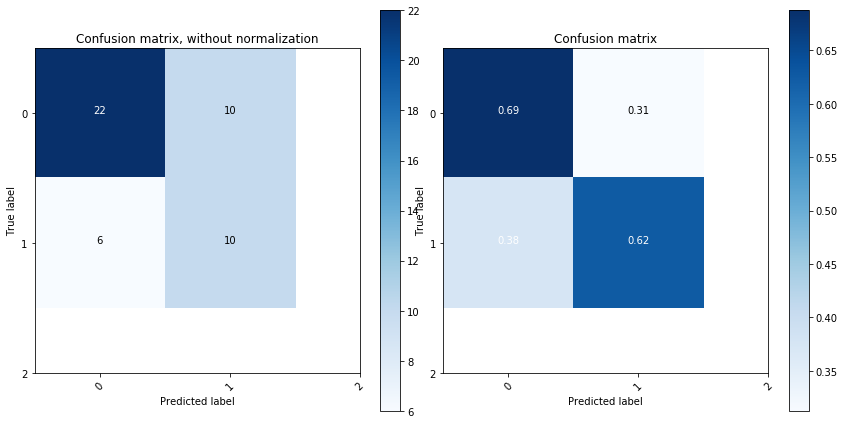

In [251]:
eval_plot(response_df['avg_embed_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[19 13]
 [ 2 14]]
Normalized confusion matrix
[[0.59375 0.40625]
 [0.125   0.875  ]]


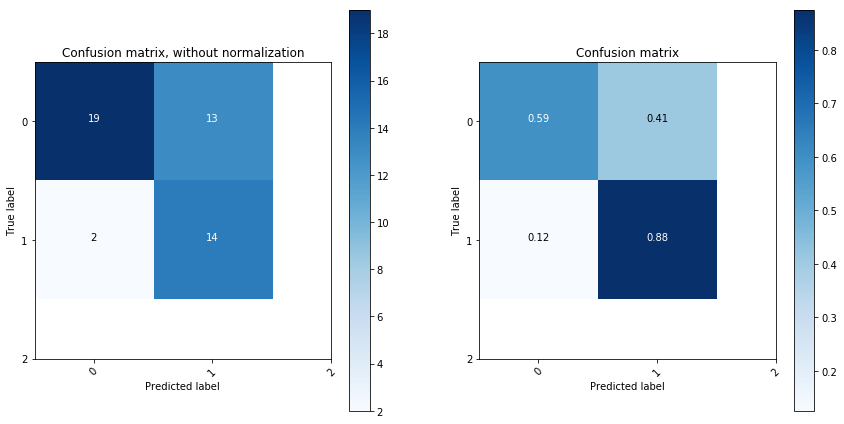

In [77]:
eval_plot(response_df['idf_embed_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[22 10]
 [ 4 12]]
Normalized confusion matrix
[[0.6875 0.3125]
 [0.25   0.75  ]]


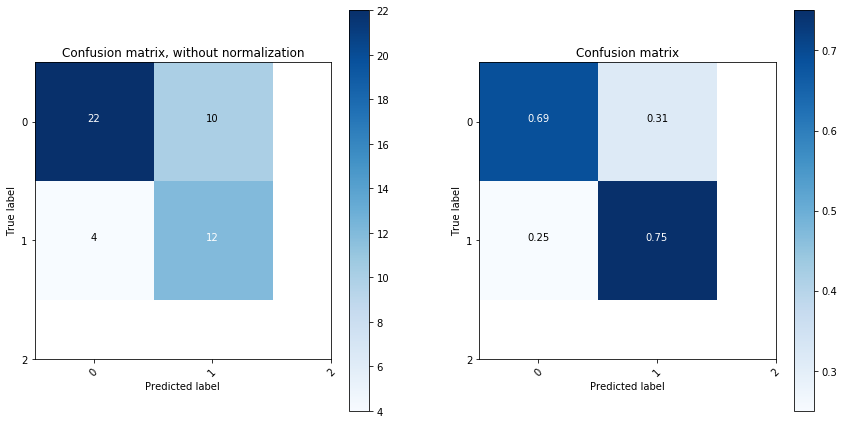

In [78]:
eval_plot(response_df['net_sim'], response_df['true_label'])